# Data Preprocessing

## Extract data of perishable foods from 2016

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)

In [2]:
pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=b139f2f305d98b749ac84cb4504622efd2cb264fa59c97bb79759fa7cf358d9a
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [3]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.7 MB/s 
     |████████████████████████████████| 209 kB 41.3 MB/s 
     |████████████████████████████████| 81 kB 9.4 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 147 kB 56.4 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 112 kB 77.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=31aee13d93e5b46a4df60576823171bade8fb59691ed3228f45fcb43a7764bd3
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#unzip the train dataset
!unzip "/content/drive/MyDrive/train.zip" -d "/content/"

Archive:  /content/drive/MyDrive/train.zip
  inflating: /content/train.csv      


In [6]:
data = pd.read_csv(
     "train.csv", usecols=[0,1, 2, 3, 4, 5], dtype={'onpromotion': bool}, 
     converters={'unit_sales': lambda x: np.log1p(float(x)) if float(x) > 0 else 0}, # removing negatives
     parse_dates=['date'], skiprows=range(1, 66458909) #from 2016 
 )
item = pd.read_csv('items.csv')
holiday = pd.read_csv('holidays_events.csv',parse_dates=['date'])
oil= pd.read_csv('oil.csv',parse_dates=['date'])
store = pd.read_csv('stores.csv')
transactions = pd.read_csv('transactions.csv',parse_dates=['date'])
data = pd.merge(data, item, on='item_nbr', how='left')
perishable =data[data['perishable']==1] #filter perishable foods

In [7]:
# reduce the memory use of data
def reduce_mem_usage(df_path):
    df = perishable
    start_mem = df.memory_usage().sum() / 1024**2
    numerics = ['int8','int16','int32','int64','float16','float32','float64']
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if(c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max):
                    df[col] = df[col].astype(np.int8)
                elif (c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max):
                    df[col] = df[col].astype(np.int16)
                elif (c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df  
  
  
perishable = reduce_mem_usage(perishable)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Memory usage after optimization is: 565.21 MB
Decreased by 46.6%


In [8]:
train = perishable[['date','store_nbr','item_nbr','unit_sales','onpromotion']]
#split train and test dataset
df_train = train[train.date<'2017-08-15'] 
df_test = train[(train.date=='2017-08-15')][['date','store_nbr','item_nbr','onpromotion']]

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15196547 entries, 4 to 59038122
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int8          
 2   item_nbr     int32         
 3   unit_sales   float16       
 4   onpromotion  bool          
dtypes: bool(1), datetime64[ns](1), float16(1), int32(1), int8(1)
memory usage: 347.8 MB


##Basic Exploration

###Holiday

In [10]:
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [11]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [12]:
print('Types of holiday type: {}'.format(holiday.type.unique()))
print('Types of holiday locale: {}'.format(holiday.locale.unique()))
print('Types of holiday locale_name: {}'.format(holiday.locale_name.unique()))

Types of holiday type: ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
Types of holiday locale: ['Local' 'Regional' 'National']
Types of holiday locale_name: ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']


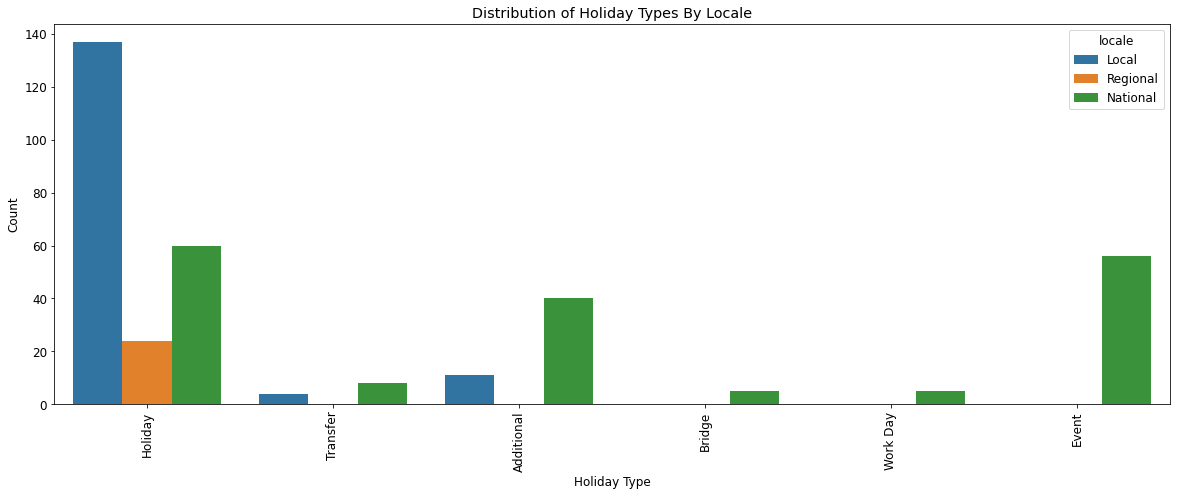

In [13]:
plt.close('all')
plt.figure(figsize=(20,7))
plt.rcParams['font.size'] = 12.0
sns.countplot(data=holiday, x='type', hue='locale')
plt.xticks(rotation='vertical')
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.title('Distribution of Holiday Types By Locale')
plt.show()

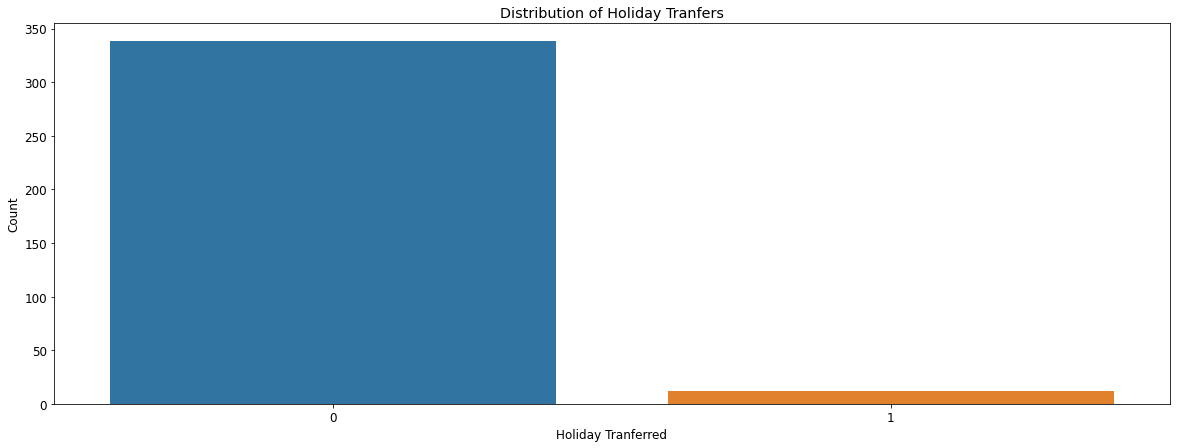

In [14]:
def tran(x):
    if x:
        return 1
    else:
        return 0

holiday['transferred'] = holiday['transferred'].map(lambda x: tran(x))

plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=holiday, x='transferred')
#plt.xticks(rotation='vertical')
plt.xlabel('Holiday Tranferred')
plt.ylabel('Count')
plt.title('Distribution of Holiday Tranfers')
plt.show()

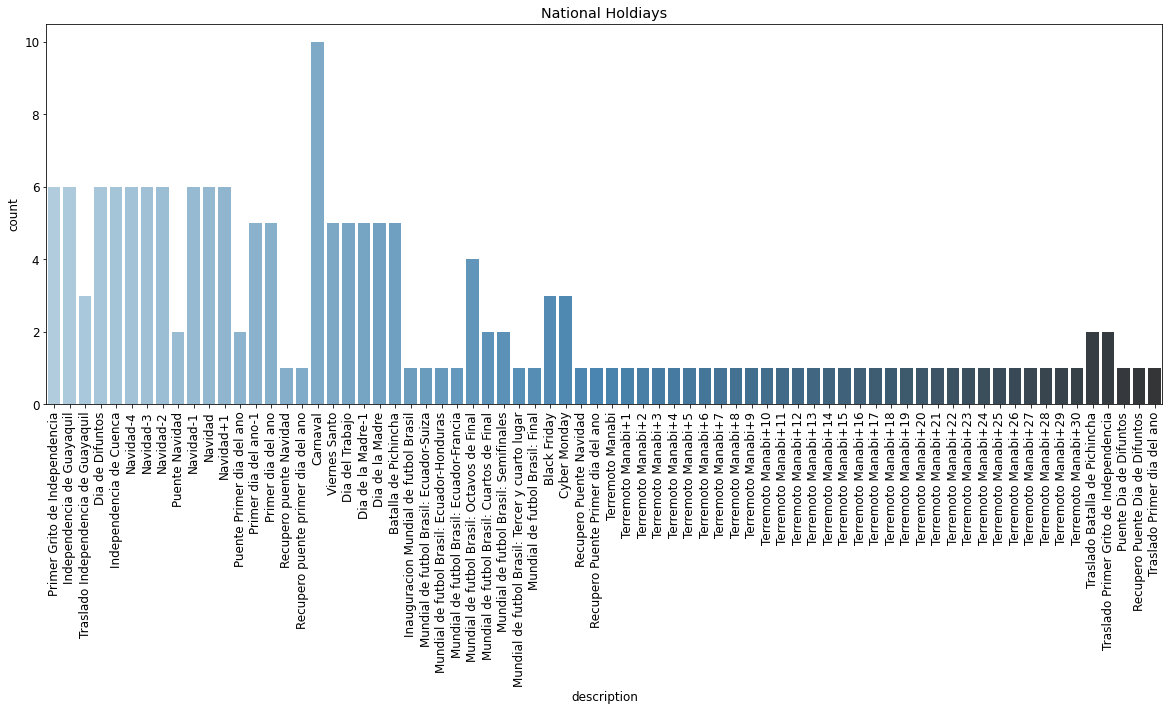

In [15]:
local = holiday[holiday['locale']=='Local']
regional = holiday[holiday['locale']=='Regional']
national = holiday[holiday['locale']=='National']
plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=national, x='description', palette='Blues_d')
plt.xticks(rotation='vertical')
plt.title('National Holdiays')
plt.show()

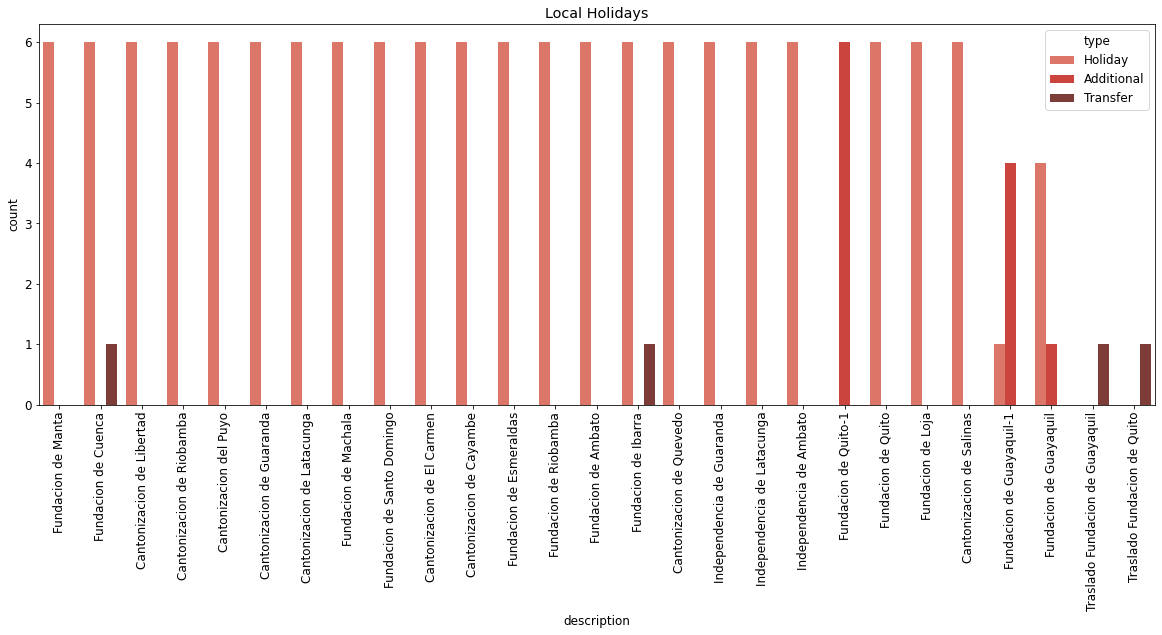

In [16]:
plt.close('all')

plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=local, x='description', hue='type', palette="Reds_d")
plt.xticks(rotation='vertical')
plt.title('Local Holidays')
plt.show()

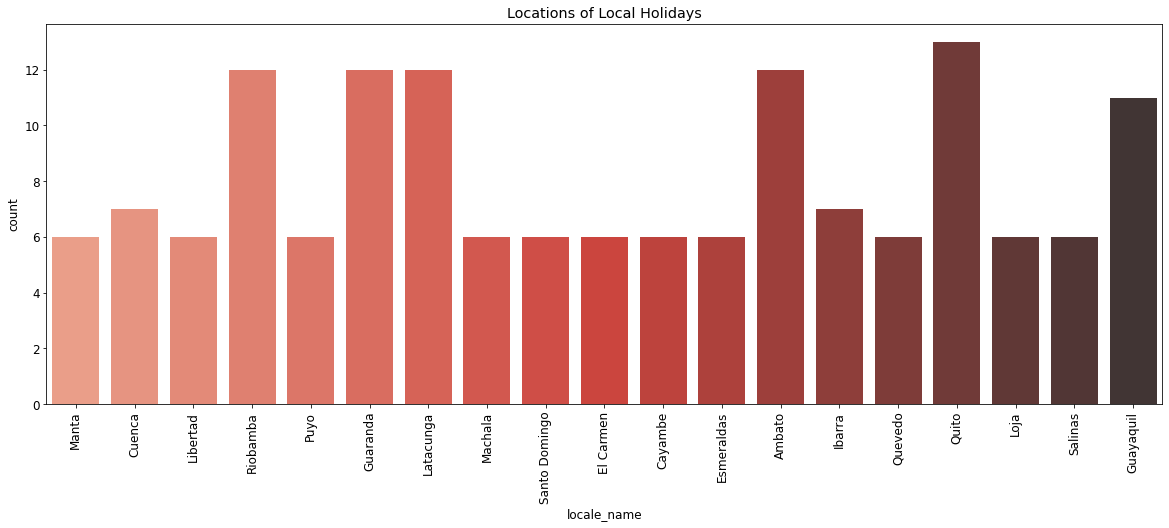

In [17]:
plt.close('all')

plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=local, x='locale_name', palette="Reds_d")
plt.xticks(rotation='vertical')
plt.title('Locations of Local Holidays')
plt.show()

###Store

In [18]:
store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [19]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [20]:
pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
#pip install folium
import folium
from operator import add
import random as rd 
from functools import partial

In [22]:
from geopy.geocoders import Nominatim
store_loca = {}
def geocodeN(address):
    gps=Nominatim(user_agent="GetLoc")
    #limit the country only to Ecuador
    geocode = lambda query: gps.geocode("%s,Ecuador" % query) 
    location = geocode(address)
    store_loca[city] = [location.latitude,location.longitude]

In [23]:
for city in store.city.unique():
  geocodeN(city)

In [24]:
store_loca

{'Quito': [-0.2201641, -78.5123274],
 'Santo Domingo': [-0.34018899999999996, -79.17154939601922],
 'Cayambe': [-0.0036006, -78.04762331470755],
 'Latacunga': [-0.9340311, -78.6145758],
 'Riobamba': [-1.6732765, -78.6482479],
 'Ibarra': [0.3477433, -78.1169906],
 'Guaranda': [-1.5922898, -79.0015614],
 'Puyo': [-1.4854777, -77.9969666],
 'Ambato': [-1.2422413, -78.6287594],
 'Guayaquil': [-2.2895167, -80.0983887437901],
 'Salinas': [-2.2079292, -80.967163],
 'Daule': [-1.92000685, -79.91293069792368],
 'Babahoyo': [-1.8009022, -79.5338214],
 'Quevedo': [-1.0243508, -79.4663323],
 'Playas': [-2.6356397, -80.3913928],
 'Libertad': [-1.0172477, -79.4454347],
 'Cuenca': [-2.8974072, -79.0041726],
 'Loja': [-4.0528506, -79.8053425],
 'Machala': [-3.2588565, -79.9588518],
 'Esmeraldas': [0.7343619, -79.3858867],
 'Manta': [-1.0321137999999999, -80.82236849673265],
 'El Carmen': [-2.1806779, -79.8789297]}

In [25]:
col={'A':'red','B':'blue','C':'green','D':'pink','E':'beige',0:'red',1:'blue',2:'green',3:'darkblue',4:'pink',5:'beige'}

def add_city_map(name,typ):
    folium.Marker(
         location=list(store_loca.get(name)),
         icon=folium.Icon(color=col.get(typ), icon='shopping-cart'),
    ).add_to(map_Ecuador)

map_Ecuador=folium.Map(location=[-1.233333, -78.516667],zoom_start=7)
[add_city_map(x,y) for x,y in zip(store.city,store.type)]
map_Ecuador

Based on the calculation, the corresponding weather station of each city have been presented.
Later, the average daily temperature of station will be append to the train dataset for further exploration.

### Oil

In [26]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [27]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


Since the price of oil on the weekend will not be provided, therefore it is reasonable to see the correlation between the missing value of oil price and dayof week 

In [28]:
oil['dayofweek']=oil['date'].dt.dayofweek

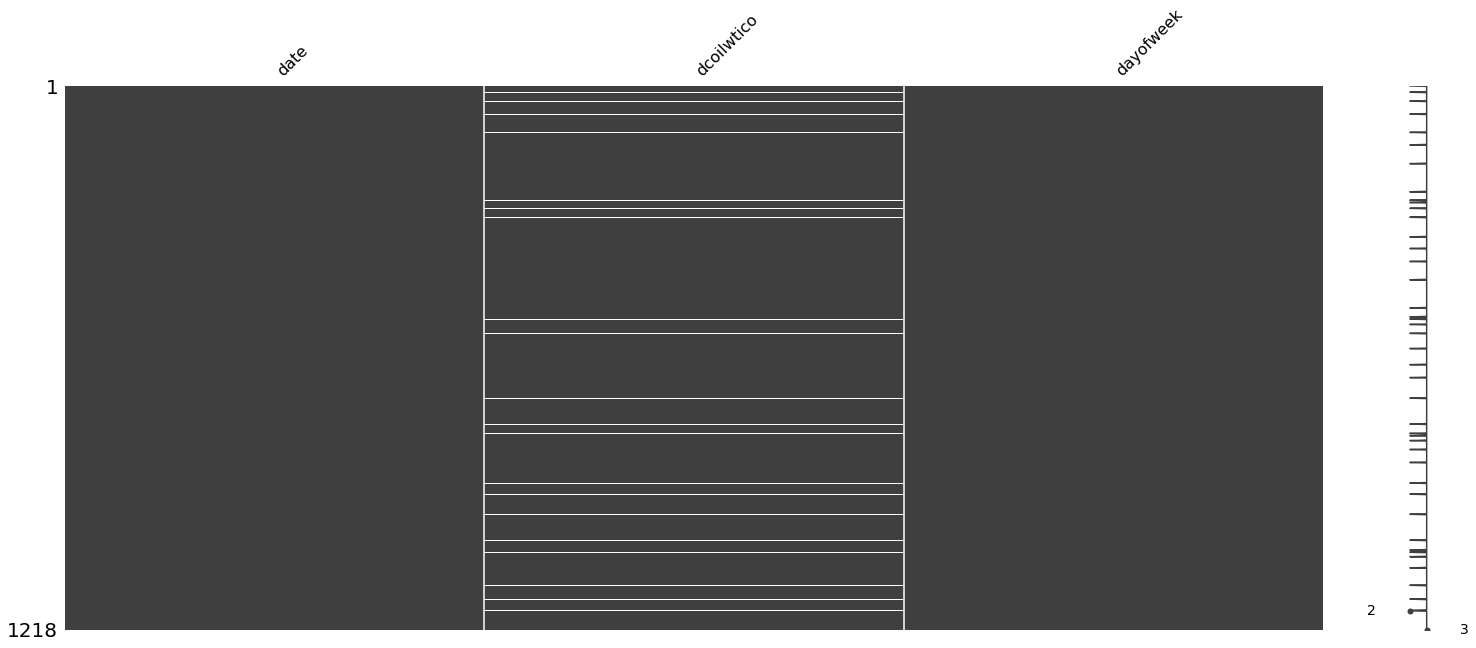

In [29]:
import missingno as msno
msno.matrix(oil)

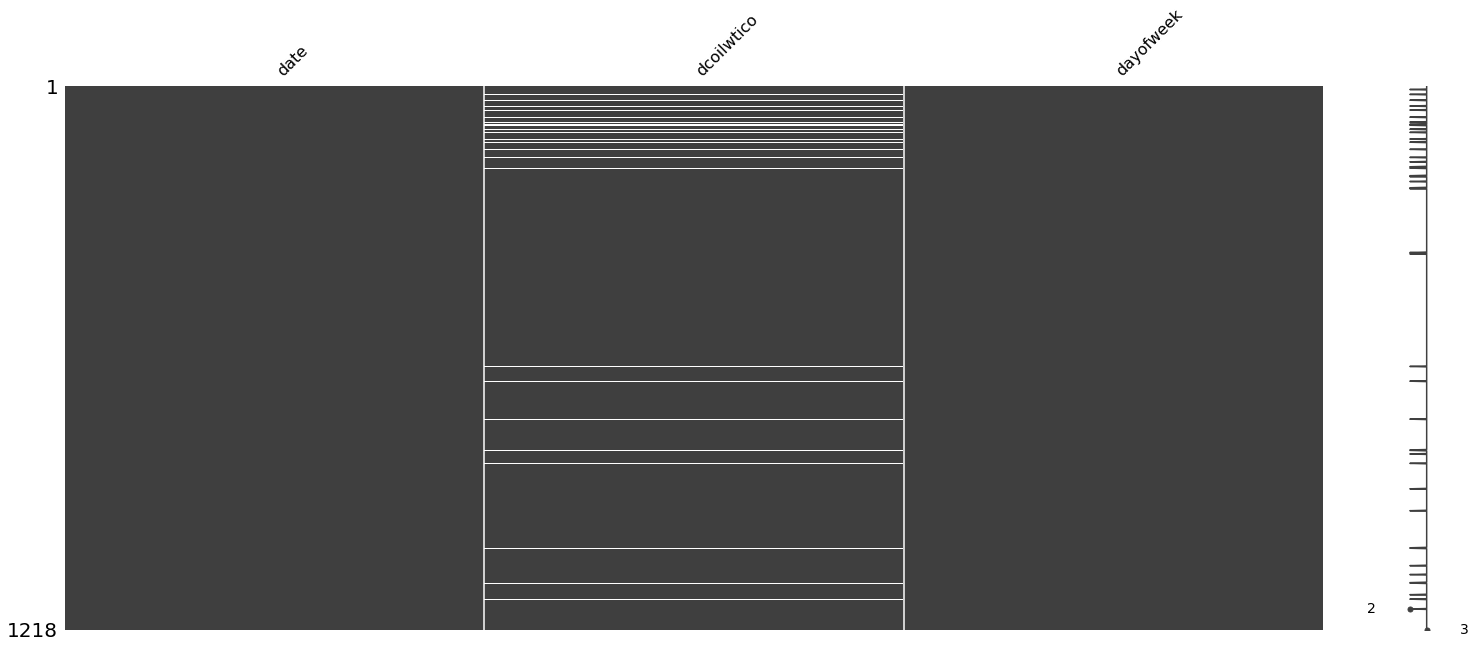

In [30]:
msno.matrix(oil.sort_values('dayofweek'))

In [31]:
oil[oil.dcoilwtico.isnull()].dayofweek.unique()

array([1, 0, 4, 3, 2])

However,according to the missing value matrix and the check of dayofweek, missing value of oil price not only missed during the weekeds.
The detailed data exploration and missing value imputation will be presented later.

### Item

In [32]:
item.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [33]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.2+ KB


###Transaction

In [34]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [35]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


### Combination

In [36]:
train = pd.merge(perishable, store, on='store_nbr', how='left')
train = train.merge(oil, on='date', how='left')
train = train.merge(holiday, on = 'date', how = 'left')

In [37]:
#since the transffered days have been transffered in 'type' columns, it will be deleted here
#description of holiday date is also not useful here, it will also been deleted
#train = train.drop(['locale', 'locale_name','description','transferred'], axis=1)
train = train.rename(columns={"type_y": "day_type", "type_x": "type","dcoilwtico":"oil_price"})

In [38]:
train = pd.merge(train, transactions, on=['date','store_nbr'], how='left')

In [39]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,type,cluster,oil_price,dayofweek,day_type,locale,locale_name,description,transferred,transactions
0,66458912,2016-01-01,25,108701,1.098633,True,DELI,2644,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN
1,66458935,2016-01-01,25,123347,3.433594,False,DAIRY,2114,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN
2,66458938,2016-01-01,25,127547,1.386719,True,EGGS,2502,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN
3,66458941,2016-01-01,25,129635,3.611328,False,DAIRY,2112,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN
4,66458944,2016-01-01,25,153239,2.708984,False,BREAD/BAKERY,2712,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN


## Weather data import

In order to introduce the external factor: weather into the research, temperature of each city in Ecuador have been collected from the NOAA website, which is a part of the science and technology sector of the US dpartment of Commerce

In [40]:
#get the latitude and longitude of the weather stations
station_loca= {'ECM00084270':[-4.033,-79.2],
        'ECM00084132':[-0.917,-75.417],
        'EC000000006':[-1.1,-79.467],
        'ECM00084135':[-1.033,-80.45],
        'ECM00084036':[0.6,-77.817],
        'ECM00084179':[-1.5,-77.9],
        'ECM00084050':[0.017,-79.367],
        'ECM00084088':[-0.35,-78.55],
        'ECM00084226':[-2.55,-78.933]
}

In [41]:
station_loca

{'ECM00084270': [-4.033, -79.2],
 'ECM00084132': [-0.917, -75.417],
 'EC000000006': [-1.1, -79.467],
 'ECM00084135': [-1.033, -80.45],
 'ECM00084036': [0.6, -77.817],
 'ECM00084179': [-1.5, -77.9],
 'ECM00084050': [0.017, -79.367],
 'ECM00084088': [-0.35, -78.55],
 'ECM00084226': [-2.55, -78.933]}

In [42]:
from math import radians, cos, sin, asin, sqrt
distance = {}
#calculate the distance based on the latitude and longitude
def geodistance(lat1,lng1,lat2,lng2):
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    dis=2*asin(sqrt(a))*6371*1000
    return dis 

for i in store_loca.keys():
  dis={}
  for j in station_loca.keys():
    lat1 = store_loca[i][0]
    lng1 = store_loca[i][1]
    lat2 = station_loca[j][0]
    lng2 = station_loca[j][1]
    dis[j] = geodistance(lat1,lng1,lat2,lng2)
  distance[i]=dis
#get the most close station name of each city
for i in distance.keys():
  a = min(distance[i],key=distance[i].get)
  print(i+':'+a)

Quito:ECM00084088
Santo Domingo:ECM00084050
Cayambe:ECM00084088
Latacunga:ECM00084088
Riobamba:ECM00084179
Ibarra:ECM00084036
Guaranda:EC000000006
Puyo:ECM00084179
Ambato:ECM00084179
Guayaquil:ECM00084226
Salinas:ECM00084135
Daule:EC000000006
Babahoyo:EC000000006
Quevedo:EC000000006
Playas:ECM00084226
Libertad:EC000000006
Cuenca:ECM00084226
Loja:ECM00084270
Machala:ECM00084270
Esmeraldas:ECM00084050
Manta:ECM00084135
El Carmen:ECM00084226


Based on the distance calculation between cities and the weather stations, the closest weather station of each cities have been presented as above. 
In this case, temperature file will be rename by the city name. 

In [43]:
#Load the temperature file 
Ibarra = pd.read_csv('Ibarra_ECM00084036.csv',usecols=[1,12],header=0,names=['date','temperature'],parse_dates=['date'])
SantoDomingo_Esmeraldas=pd.read_csv('Santo DomingoEsmeraldas_ECM00084050.csv',usecols=[1,12],header=0,names=['date','temperature'],parse_dates=['date'])
Quito_Cayambe_Latacunga= pd.read_csv('QuitoCayambeLatacunga_ECM00084088.csv',usecols=[1,12],header=0,names=['date','temperature'],parse_dates=['date'])
Riobamba_Ambato_Libertad_Puyo = pd.read_csv('RiobambaAmbatoLibertadPuyo_ECM00084179.csv',usecols=[1,12],header=0,names=['date','temperature'],parse_dates=['date'])
Guaranda_Daule_Babahoyo_Quevedo= pd.read_csv('GuarandaDauleBabahoyoQuevedo_EC000000006.csv',usecols=[1,12],header=0,names=['date','temperature'],parse_dates=['date'])
Salinas_Manta=pd.read_csv('SalinasManta_ECM00084135.csv',usecols=[1,12],header=0,names=['date','temperature'],parse_dates=['date'])
Guayaquil_Playas_Cuenca_ElCarmen=pd.read_csv('GuayaquilPlayasCuencaEl Carmen_ECM00084226.csv',usecols=[1,12],header=0,names=['date','temperature'],parse_dates=['date'])
Loja_Machala=pd.read_csv('LojaMachala_ECM00084270.csv',usecols=[1,12],header=0,names=['date','temperature'],parse_dates=['date'])

In [44]:
#add new columns of city
Ibarra['city1']='Ibarra'
Ibarra['city']='Ibarra'
Riobamba_Ambato_Libertad_Puyo['city1']='Riobamba'
Riobamba_Ambato_Libertad_Puyo['city2']='Ambato'
Riobamba_Ambato_Libertad_Puyo['city3']='Libertad'
Riobamba_Ambato_Libertad_Puyo['city4']='Puyo'
Riobamba_Ambato_Libertad_Puyo['city']='Riobamba,Ambato,Libertad,Puyo'
Loja_Machala['city1']='Loja'
Loja_Machala['city2']='Machala'
Loja_Machala['city']='Loja,Machala'
Guaranda_Daule_Babahoyo_Quevedo['city1']='Guaranda'
Guaranda_Daule_Babahoyo_Quevedo['city2']='Daule'
Guaranda_Daule_Babahoyo_Quevedo['city3']='Babahoyo'
Guaranda_Daule_Babahoyo_Quevedo['city4']='Quevedo'
Guaranda_Daule_Babahoyo_Quevedo['city']='Guaranda,Daule,Babahoyo,Quevedo'
Quito_Cayambe_Latacunga['city1']='Quito'
Quito_Cayambe_Latacunga['city2']='Cayambe'
Quito_Cayambe_Latacunga['city3']='Latacunga'
Quito_Cayambe_Latacunga['city']='Quito,Cayambe,Latacunga'
SantoDomingo_Esmeraldas['city1']='Santo Domingo'
SantoDomingo_Esmeraldas['city2']='Esmeraldas'
SantoDomingo_Esmeraldas['city']='Santo Domingo,Esmeraldas'
Salinas_Manta['city1']='Salinas'
Salinas_Manta['city2']='Manta'
Salinas_Manta['city']='Salinas,Manta'
Guayaquil_Playas_Cuenca_ElCarmen['city1']='Guayaquil'
Guayaquil_Playas_Cuenca_ElCarmen['city2']='Playas'
Guayaquil_Playas_Cuenca_ElCarmen['city3']='Cuenca'
Guayaquil_Playas_Cuenca_ElCarmen['city4']='El Carmen'
Guayaquil_Playas_Cuenca_ElCarmen['city']='Guayaquil,Playas,Cuenca,El Carmen'

In [45]:
#append all the weather data together
weather = Ibarra.append([Riobamba_Ambato_Libertad_Puyo,Loja_Machala,Guaranda_Daule_Babahoyo_Quevedo,Quito_Cayambe_Latacunga,SantoDomingo_Esmeraldas,Salinas_Manta,Guayaquil_Playas_Cuenca_ElCarmen],ignore_index=True)
#split date for cities that share one table
weather.city=weather.city.apply(lambda x:x.split(','))
weather=weather.explode('city')
#drop meaningless columns
weather.drop(columns={'city1','city2','city3','city4'},axis=1,inplace=True)

In [46]:
#append tmperature data with train dataset
train=pd.merge(train,weather,on=['date','city'],how='left')
train

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,type,cluster,oil_price,dayofweek,day_type,locale,locale_name,description,transferred,transactions,temperature
0,66458912,2016-01-01,25,108701,1.098633,True,DELI,2644,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN,277.0
1,66458935,2016-01-01,25,123347,3.433594,False,DAIRY,2114,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN,277.0
2,66458938,2016-01-01,25,127547,1.386719,True,EGGS,2502,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN,277.0
3,66458941,2016-01-01,25,129635,3.611328,False,DAIRY,2112,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN,277.0
4,66458944,2016-01-01,25,153239,2.708984,False,BREAD/BAKERY,2712,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN,277.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15589329,125497024,2017-08-15,54,2081056,0.693359,False,PREPARED FOODS,2986,1,El Carmen,Manabi,C,3,47.57,1.0,Holiday,Local,Riobamba,Fundacion de Riobamba,0.0,802.0,NaN
15589330,125497025,2017-08-15,54,2081064,3.912109,False,PREPARED FOODS,2966,1,El Carmen,Manabi,C,3,47.57,1.0,Holiday,Local,Riobamba,Fundacion de Riobamba,0.0,802.0,NaN
15589331,125497026,2017-08-15,54,2081095,1.386719,False,PREPARED FOODS,2962,1,El Carmen,Manabi,C,3,47.57,1.0,Holiday,Local,Riobamba,Fundacion de Riobamba,0.0,802.0,NaN
15589332,125497027,2017-08-15,54,2081161,3.738281,False,PREPARED FOODS,2966,1,El Carmen,Manabi,C,3,47.57,1.0,Holiday,Local,Riobamba,Fundacion de Riobamba,0.0,802.0,NaN


In [47]:
train['day_type'].replace('NaN','Work Day',inplace=True)
train['day_type'].replace(np.nan,'Work Day',inplace=True)
train['year']=train['date'].dt.year
train['month']=train['date'].dt.month
train['day']=train['date'].dt.day

In [48]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,type,cluster,oil_price,dayofweek,day_type,locale,locale_name,description,transferred,transactions,temperature,year,month,day
0,66458912,2016-01-01,25,108701,1.098633,True,DELI,2644,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN,277.0,2016,1,1
1,66458935,2016-01-01,25,123347,3.433594,False,DAIRY,2114,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN,277.0,2016,1,1
2,66458938,2016-01-01,25,127547,1.386719,True,EGGS,2502,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN,277.0,2016,1,1
3,66458941,2016-01-01,25,129635,3.611328,False,DAIRY,2112,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN,277.0,2016,1,1
4,66458944,2016-01-01,25,153239,2.708984,False,BREAD/BAKERY,2712,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,0.0,NaN,277.0,2016,1,1


# EDA

In [49]:
train['unit_sales'] = train['unit_sales'].astype('float32')
train['temperature'] = train['temperature'].astype('float32')
train['oil_price'] = train['oil_price'].astype('float32')

## Items

### Top 5 item families across different store types

In [ ]:
train['unit_sales']=train['unit_sales'].astype('float32')

In [ ]:
def aggregate_level1(df):
    '''writing a function to get item and store level summary metrics for a specific year'''
#day-store level
    sale_day_store_level=df.groupby(['year','month','day','store_nbr'],as_index=False)['unit_sales'].agg(['sum','count'])
    #drop index and rename
    sale_day_store_level=sale_day_store_level.reset_index().rename(columns={'sum':'store_sales','count':'item_variety'})
#day-item level  
    sale_day_item_level=df.groupby(['year','month','day','item_nbr'],as_index=False)['unit_sales'].agg(['sum','count'])
    #drop index and rename
    sale_day_item_level=sale_day_item_level.reset_index().rename(columns={'sum':'item_sales','count':'store_spread'})
#store item level   
    sale_store_item_level=df.groupby(['year','store_nbr','item_nbr'],as_index=False)['unit_sales'].agg(['sum','count'])
    #drop index and rename
    sale_store_item_level=sale_store_item_level.reset_index().rename(columns={'sum':'item_sales','count':'entries'})

    return sale_day_store_level,sale_day_item_level,sale_store_item_level

sale_day_store_level,sale_day_item_level,sale_store_item_level=aggregate_level1(train)

In [ ]:
#Creating store level metrics
sale_store_level=sale_day_store_level.groupby(['store_nbr'],as_index=False)['store_sales'].agg(['sum'])

# Here the group by gives a multiindex , removing that
sale_store_level.columns = sale_store_level.columns
sale_store_level=sale_store_level.reset_index()

In [ ]:
items = pd.read_csv('items.csv')
store=store[['store_nbr','type']]

In [ ]:
store_items=pd.merge(sale_store_item_level,items,on='item_nbr')
store_items=pd.merge(store_items,store,on='store_nbr')
store_items['item_sales']=store_items['item_sales']

In [ ]:
store_items=pd.merge(sale_store_item_level,items,on='item_nbr')
store_items=pd.merge(sale_store_item_level,store,on='store_nbr')
store_items['item_sales']=store_items['item_sales']
store_items=pd.merge(sale_store_item_level,store,on='store_nbr')

In [ ]:
store_items=pd.merge(sale_store_item_level,items,on='item_nbr')
store_items=store_items.merge(store,on='store_nbr',how='left')

In [ ]:
#item
# top selling items by store type
top_items_by_type=store_items.groupby(['type','item_nbr'])['item_sales'].sum()
top_items_by_type=top_items_by_type.reset_index().sort_values(['type','item_sales'],ascending=[True,False])

#get top 5
top_items_by_type=top_items_by_type.groupby(['type']).head(5)


#class
# top selling item class by store type
top_class_by_type=store_items.groupby(['type','class'])['item_sales'].sum()
top_class_by_type=top_class_by_type.reset_index().sort_values(['type','item_sales'],ascending=[True,False])

#get top 5
top_class_by_type=top_class_by_type.groupby(['type']).head(5)


#family
# top selling item family by store type
top_family_by_type=store_items.groupby(['type','family'])['item_sales'].sum()
top_family_by_type=top_family_by_type.reset_index().sort_values(['type','item_sales'],ascending=[True,False])

#get top 5
top_family_by_type=top_family_by_type.groupby(['type']).head(5)

<Figure size 864x360 with 0 Axes>

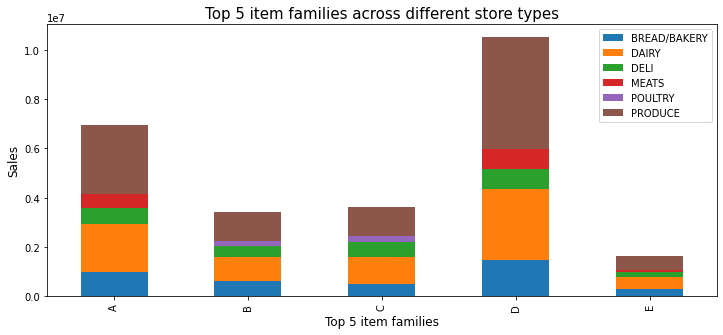

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

x=top_family_by_type.pivot(index='type',columns='family')
x.plot.bar(stacked=True,figsize=(12,5))
y=x.columns.droplevel(0).values
#print(y)
plt.ylabel('Sales', fontsize=12)
plt.xlabel('Top 5 item families', fontsize=12)
plt.title('Top 5 item families across different store types', fontsize=15)
plt.xticks(rotation='vertical')
plt.legend(y)
plt.show()

It is obvious that produced food and dairy are the top2 most popular foods in among 5 store types

###New Item check

In [ ]:
a = train[train.year==2016].groupby(['store_nbr'],as_index=False).agg({'item_nbr':'count'})
b = train[train.year==2017].groupby(['store_nbr'],as_index=False).agg({'item_nbr':'count'})
c = a.merge(b,on='store_nbr',how='inner')
c = c.rename(columns={"item_nbr_x": "item_nbr_2016", "item_nbr_y": "item_nbr_2017"})

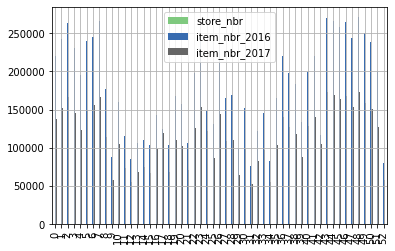

In [ ]:
c.plot(kind='bar',grid=True,colormap='Accent',stacked=False)

In [ ]:
test_item = train[train.date=='2017-08-14'].item_nbr.to_list()
train_item = train[(train.date<'2017-08-14')&(train.date>='2017-03-01')].item_nbr.to_list()

In [ ]:
diff_list = list(set(test_item) - set(train_item))
diff_list

[]

Though from the picture,the count of item number in each store has obviouse difference between 2016 and 2017, there is no new item appeared in 2017-8-14.

## Transactions

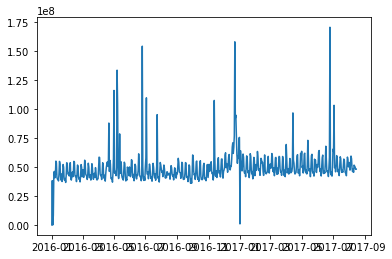

In [ ]:
daily_sales = train[['date','transactions']].groupby(['date'],as_index=False).agg({'transactions':'sum'})
plt.plot(daily_sales.date,daily_sales.transactions)
plt.rcParams['figure.figsize'] = (10,3)

### Transactions & Month 

In [ ]:
import altair as alt
train['Month'] = train['date'].dt.strftime('%B')
month = train['Month'].value_counts().to_frame().reset_index().rename(columns={'index':'Month','Month':'count'}).sort_values(by='Month',ascending =False)
print(month)

        Month    count
11  September   737512
10    October   772552
9    November   793446
0         May  1716746
3       March  1597861
2        June  1672763
1        July  1708953
5     January  1539637
6    February  1458288
8    December   820163
7      August  1176309
4       April  1595104


In [ ]:
bars = alt.Chart(month).mark_bar(color="purple").encode(
    x='Month',
    y='count',
    tooltip=[alt.Tooltip('count:Q')]
    
)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-7 ,
    size=15,
).encode(text='count')

(bars + text).properties(
    width=800,
    height=800,
    title="Monthly Transactions")

alt.LayerChart(...)

From 2016, the number of transactions in May,July,June are the top3 among all the monthes; While that in November,December and other months during winter seasons are very low. 

### Transaction & State

In [ ]:
train.groupby(['state','city'])['store_nbr'].count()

state                           city         
Azuay                           Cuenca           1023285
Bolivar                         Guaranda          171914
Chimborazo                      Riobamba          173566
Cotopaxi                        Latacunga         328469
El Oro                          Machala           547671
Esmeraldas                      Esmeraldas        221980
Guayas                          Daule             372047
                                Guayaquil        2089407
                                Libertad          268615
                                Playas            138573
Imbabura                        Ibarra            184805
Loja                            Loja              324876
Los Rios                        Babahoyo          249754
                                Quevedo           203758
Manabi                          El Carmen         137289
                                Manta             407293
Pastaza                         Puyo      

In [ ]:
train.groupby(['state','city'],as_index=False).agg({'unit_sales':'sum'}).rename(columns={'unit_sales':'total_sales'})

,state,city,total_sales
0,Azuay,Cuenca,1.869722e+06
1,Bolivar,Guaranda,2.711030e+05
2,Chimborazo,Riobamba,2.662884e+05
3,Cotopaxi,Latacunga,4.865276e+05
4,El Oro,Machala,9.750562e+05
5,Esmeraldas,Esmeraldas,3.761322e+05
6,Guayas,Daule,7.105346e+05
7,Guayas,Guayaquil,3.819073e+06
8,Guayas,Libertad,4.620729e+05
9,Guayas,Playas,2.009928e+05


In [ ]:
state_city=train.groupby(['state','city'],as_index=False).agg({'unit_sales':'sum'}).rename(columns={'unit_sales':'total_sales'})
state_city['state'] = state_city['state'].astype('category')
state_city['city'] = state_city['city'].astype('category')
state_city['state_city'] = state_city['state'].astype(str)+"-"+state_city['city'].astype(str)

bars=alt.Chart(state_city).mark_bar().encode(
    x='total_sales',
    y='state',
    color=alt.Color('city',title='city'),
    tooltip=[alt.Tooltip('state_city:N'),
             alt.Tooltip('state:N'),
             alt.Tooltip('total_sales:Q'),
            ]
    
).properties(
    width=600,
    height=400,
    title="Store sales of each state")

bars

alt.Chart(...)

It is obvious that the store sales of Quito in Pichina state is superisingly higher than that of other cities, and it is because Quito is the capital city.
Another city that worth paying attentino is Guayaquil, whose sales is the top 2 among all the cities. 

###Transaction & Store Type

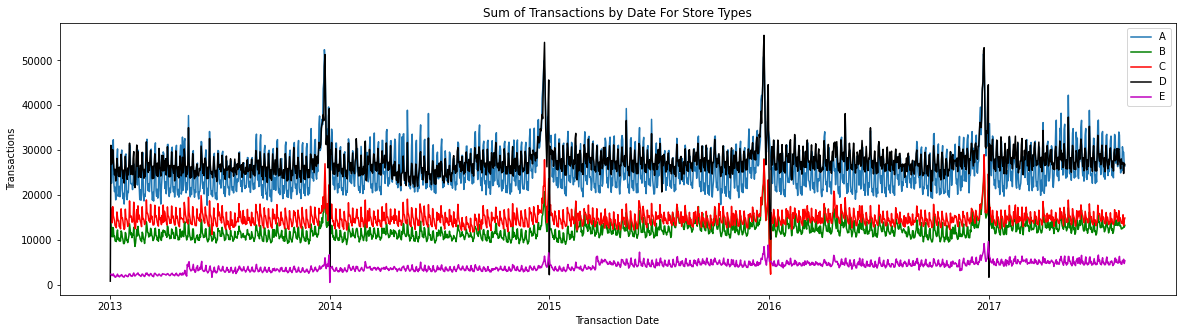

In [ ]:
transactions = pd.read_csv('transactions.csv',parse_dates=['date'])
store = pd.read_csv('stores.csv')
all = transactions.merge(store,on='store_nbr',how='left')

transactionsA=all[all['type']=='A'].drop('type', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactionsB=all[all['type']=='B'].drop('type', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactionsC=all[all['type']=='C'].drop('type', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactionsD=all[all['type']=='D'].drop('type', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactionsE=all[all['type']=='E'].drop('type', axis=1).groupby(['date']).agg({'transactions':'sum'})

plt.close('all')
plt.figure(figsize=(20,5))
plt.plot(transactionsA.index.values, transactionsA['transactions'], label='A')
plt.plot(transactionsB.index.values, transactionsB['transactions'], color='g', label='B')
plt.plot(transactionsC.index.values, transactionsC['transactions'], color='r', label='C')
plt.plot(transactionsD.index.values, transactionsD['transactions'], color='k', label='D')
plt.plot(transactionsE.index.values, transactionsE['transactions'], color='m', label='E')

plt.title('Sum of Transactions by Date For Store Types')
plt.xlabel('Transaction Date')
plt.ylabel('Transactions')

plt.legend()
plt.show()

There is no significantly difference between different store types, the higher transactions could because of the size of stores in each store type.In this case,store type will not be in included for feature engineering. 

### Transaction & Cluster

In [ ]:
transactions = pd.read_csv('transactions.csv',parse_dates=['date'])
store = pd.read_csv('stores.csv')
all = transactions.merge(store,on='store_nbr',how='left')

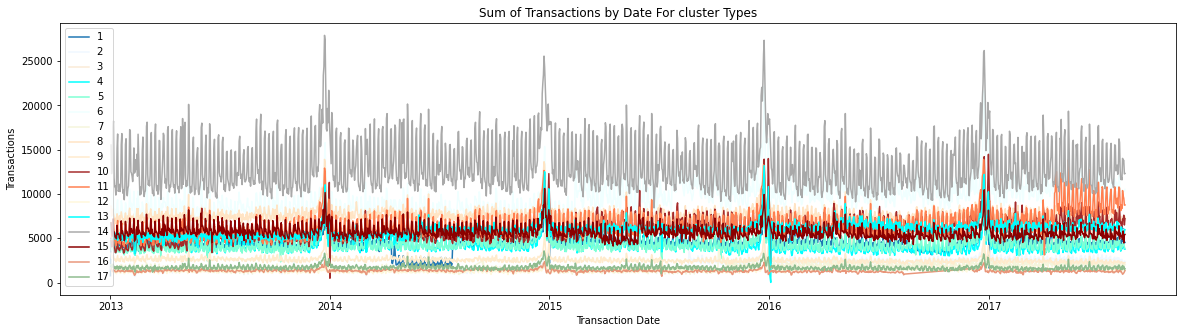

In [ ]:
transactions1=all[all['cluster']==1].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions2=all[all['cluster']==2].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions3=all[all['cluster']==3].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions4=all[all['cluster']==4].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions5=all[all['cluster']==5].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions6=all[all['cluster']==6].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions7=all[all['cluster']==7].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions8=all[all['cluster']==8].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions9=all[all['cluster']==9].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions10=all[all['cluster']==10].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions11=all[all['cluster']==11].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions12=all[all['cluster']==12].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions13=all[all['cluster']==13].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions14=all[all['cluster']==14].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions15=all[all['cluster']==15].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions16=all[all['cluster']==16].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})
transactions17=all[all['cluster']==17].drop('cluster', axis=1).groupby(['date']).agg({'transactions':'sum'})

plt.close('all')
plt.figure(figsize=(20,5))
plt.plot(transactions1.index.values, transactions1['transactions'], label='1')
plt.plot(transactions2.index.values, transactions2['transactions'], color='aliceblue', label='2')
plt.plot(transactions3.index.values, transactions3['transactions'], color='antiquewhite', label='3')
plt.plot(transactions4.index.values, transactions4['transactions'], color='aqua', label='4')
plt.plot(transactions5.index.values, transactions5['transactions'], color='aquamarine', label='5')
plt.plot(transactions6.index.values, transactions6['transactions'], color='azure', label='6')
plt.plot(transactions7.index.values, transactions7['transactions'], color='beige', label='7')
plt.plot(transactions8.index.values, transactions8['transactions'], color='bisque', label='8')
plt.plot(transactions9.index.values, transactions9['transactions'], color='blanchedalmond', label='9')
plt.plot(transactions10.index.values, transactions10['transactions'], color='brown', label='10')
plt.plot(transactions11.index.values, transactions11['transactions'], color='coral', label='11')
plt.plot(transactions12.index.values, transactions12['transactions'], color='cornsilk', label='12')
plt.plot(transactions13.index.values, transactions13['transactions'], color='cyan', label='13')
plt.plot(transactions14.index.values, transactions14['transactions'], color='darkgray', label='14')
plt.plot(transactions15.index.values, transactions15['transactions'], color='darkred', label='15')
plt.plot(transactions16.index.values, transactions16['transactions'], color='darksalmon', label='16')
plt.plot(transactions17.index.values, transactions17['transactions'], color='darkseagreen', label='17')

plt.title('Sum of Transactions by Date For cluster Types')
plt.xlabel('Transaction Date')
plt.ylabel('Transactions')

plt.legend()
plt.show()

Similarily to the store tyoe, cluster 14 seems to have higher transactions compared with others. However, since the size of stores have not been provided by the dataset, this factor will also been excluded in this dissertation.

## Sales

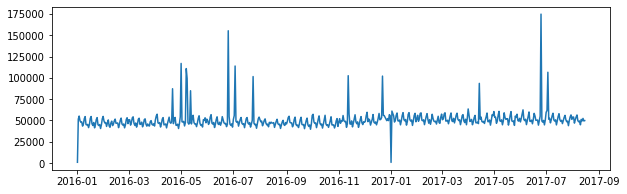

In [ ]:
daily_sales = train[['date','unit_sales']].groupby(['date'],as_index=False).agg({'unit_sales':'sum'})
plt.plot(daily_sales.date,daily_sales.unit_sales)
plt.rcParams['figure.figsize'] = (10,3)

In [ ]:
daily_sales[daily_sales.unit_sales>78000]

,date,unit_sales
111,2016-04-21,87255.289062
121,2016-05-01,116923.468750
127,2016-05-07,110901.257812
128,2016-05-08,99351.742188
132,2016-05-12,84904.765625
176,2016-06-25,155270.062500
184,2016-07-03,113889.148438
205,2016-07-24,101526.648438
316,2016-11-12,102548.039062
356,2016-12-22,102069.359375


###Sales & Holiday

In [ ]:
train[train['transferred']==True]['day_type']='Work Day'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train.day_type.unique()

array(['Holiday', 'Work Day', 'Event', 'Additional', 'Transfer', 'Bridge'],
      dtype=object)

In [ ]:
Regular = train[train.day_type=='Work Day']
Holiday = train[(train.day_type=='Holiday')]
Event = train[(train.day_type=='Event')]
Additional = train[(train.day_type=='Additional')]
Transfer = train[(train.day_type=='Transfer')]
Bridge = train[(train.day_type=='Bridge')]

In [ ]:
Regular = pd.DataFrame({'mean' : Regular.groupby("date")['transactions'].mean()}).reset_index()
Holiday = pd.DataFrame({'mean' : Holiday.groupby("date")['transactions'].mean()}).reset_index()
Event = pd.DataFrame({'mean' : Event.groupby("date")['transactions'].mean()}).reset_index()
Additional = pd.DataFrame({'mean' : Additional.groupby("date")['transactions'].mean()}).reset_index()
Transfer = pd.DataFrame({'mean' : Transfer.groupby("date")['transactions'].mean()}).reset_index()
Bridge = pd.DataFrame({'mean' : Bridge.groupby("date")['transactions'].mean()}).reset_index()

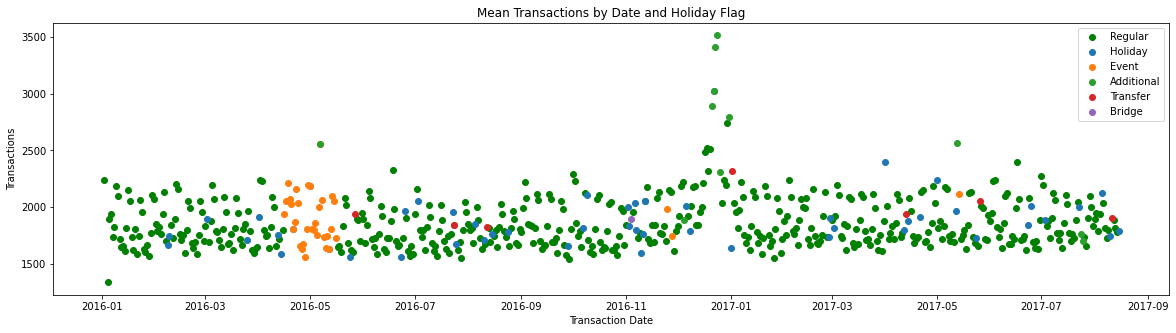

In [ ]:
plt.close('all')
plt.figure(figsize=(20,5))

plt.plot_date(Regular['date'], Regular['mean'], color='g', label='Regular')
plt.plot_date(Holiday['date'], Holiday['mean'], label='Holiday')
plt.plot_date(Event['date'], Event['mean'], label='Event')
plt.plot_date(Additional['date'], Additional['mean'], label='Additional')
plt.plot_date(Transfer['date'], Transfer['mean'], label='Transfer')
plt.plot_date(Bridge['date'], Bridge['mean'], label='Bridge')

plt.title('Mean Transactions by Date and Holiday Flag')
plt.xlabel('Transaction Date')
plt.ylabel('Transactions')

plt.legend()
plt.show()

By plotting the mean transactions on different date, it is obvious that there is not siginificant differneces between different day types. The signigicantly higher trandactions at the December of 2016 could be the Christmas Day. In this case, holiday will not be included into the feature engineering. 

### Sales & Oil Price

In [ ]:
oil_and_sales= train[['date','oil_price','unit_sales']].groupby('date').agg({'unit_sales':'sum'})
oil = train[['date','oil_price']]
oil_and_sales=oil_and_sales.merge(oil,on='date',how='left')
oil_and_sales.set_index('date',inplace=True)
oil_and_sales=oil_and_sales.rename(columns={"unit_sales": "total_sales"})

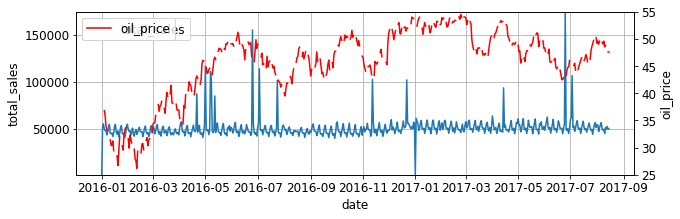

In [ ]:
import matplotlib.pyplot as plt

x =  np.array(oil_and_sales.index.tolist())
y1 =  np.array(oil_and_sales.total_sales.tolist())
y2 =  np.array(oil_and_sales.oil_price.tolist())

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y1, '-', label = 'total_sales')
ax2 = ax.twinx()
ax2.plot(x, y2, '-r', label = 'oil_price')
ax.legend(loc=0)
ax.grid()
ax.set_xlabel('date')
ax.set_ylim(800,174800)
ax.set_ylabel('total_sales')
ax2.set_ylabel('oil_price')
ax2.set_ylim(25, 55)
ax2.legend(loc=2)
plt.rcParams['figure.figsize'] = (10,3)

In [ ]:
oil_and_sales.corr(method="pearson")

,total_sales,oil_price
total_sales,1.000000,0.217495
oil_price,0.217495,1.000000


In [ ]:
oil_and_sales['diff']= oil_and_sales.oil_price.diff(1)

In [ ]:
oil_and_sales.corr(method="pearson")

,total_sales,oil_price,diff
total_sales,1.000000,0.217495,-0.00003
oil_price,0.217495,1.000000,0.00023
diff,-0.000030,0.000230,1.00000


Though Ecuador is a heavily oil depending country, there only has low-level correlation between oil price and unit sales of items,and the oil  difference of first order almost have no correlation with unit sales

In [ ]:
sale_oil = train[['date','oil_price']]
sale_oil['diff'] = train.oil_price.diff(1).values
sale_oil.merge(train[['unit_sales','date']],how='inner',on='date')
plt.plot(sale_oil['date'],sale_oil['oil_price'].diff(1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


###Sales & Promotion

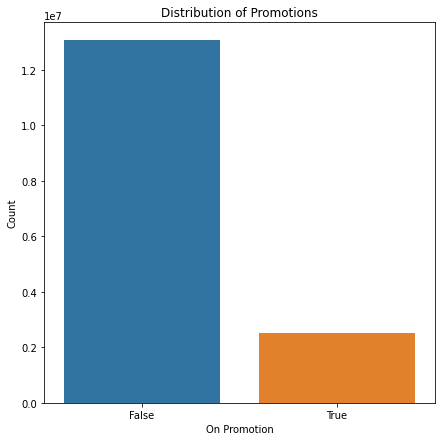

In [ ]:
promo_totals = train['onpromotion'].value_counts()
promo = pd.DataFrame(columns=['onpromotion','count'])
promo['onpromotion'] = promo_totals.index.values
promo['count'] = promo_totals.values

plt.close('all')
fig,ax=plt.subplots(figsize=(7, 7))
sns.barplot(x=promo['onpromotion'], y=promo['count'])
plt.title('Distribution of Promotions')
plt.xlabel('On Promotion')
plt.ylabel('Count')
plt.show()

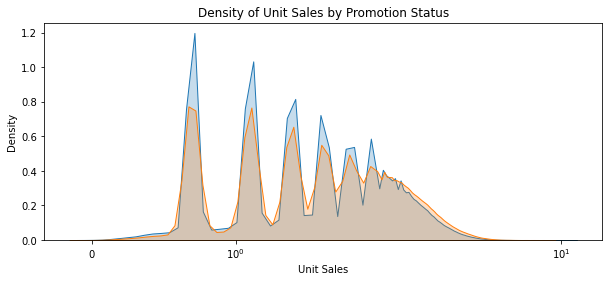

In [ ]:
falsepromo = train[train['onpromotion']==False]
truepromo = train[train['onpromotion']==True]

# Make sample sizes equal

falsepromo = falsepromo['unit_sales']
truepromo = truepromo['unit_sales']

plt.close('all')
fig,ax=plt.subplots(figsize=(10, 4))
ax.set(xscale="symlog")

sns.kdeplot(falsepromo, shade=True, label='False')
sns.kdeplot(truepromo, shade=True, label='True')
plt.title('Density of Unit Sales by Promotion Status')
plt.xlabel('Unit Sales')
plt.ylabel('Density')
plt.show()

Most of the items are not being promoted when they are purchased. However, whether or not an item is being promoted does seem to have a small positive effect on unit sales.

In [ ]:
train

,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,type,cluster,oil_price,dayofweek,day_type,locale,locale_name,description,transferred,transactions,temperature,year,month,day
0,2016-01-01,25,108701,1.098633,True,DELI,2644,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,277.0,2016,1,1
1,2016-01-01,25,123347,3.433594,False,DAIRY,2114,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,277.0,2016,1,1
2,2016-01-01,25,127547,1.386719,True,EGGS,2502,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,277.0,2016,1,1
3,2016-01-01,25,129635,3.611328,False,DAIRY,2112,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,277.0,2016,1,1
4,2016-01-01,25,153239,2.708984,False,BREAD/BAKERY,2712,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,277.0,2016,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15589329,2017-08-15,54,2081056,0.693359,False,PREPARED FOODS,2986,1,El Carmen,Manabi,C,3,47.57,1.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,802.0,NaN,2017,8,15
15589330,2017-08-15,54,2081064,3.912109,False,PREPARED FOODS,2966,1,El Carmen,Manabi,C,3,47.57,1.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,802.0,NaN,2017,8,15
15589331,2017-08-15,54,2081095,1.386719,False,PREPARED FOODS,2962,1,El Carmen,Manabi,C,3,47.57,1.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,802.0,NaN,2017,8,15
15589332,2017-08-15,54,2081161,3.738281,False,PREPARED FOODS,2966,1,El Carmen,Manabi,C,3,47.57,1.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,802.0,NaN,2017,8,15


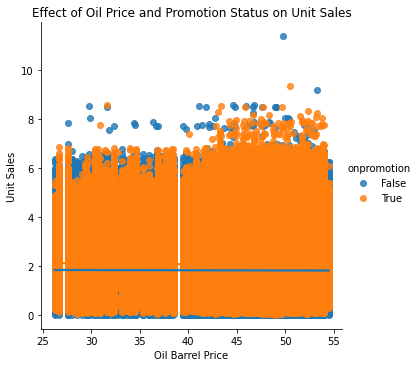

In [ ]:
plt.close('all')
sns.lmplot(data = train, x='oil_price', y='unit_sales', hue='onpromotion')
plt.xlabel('Oil Barrel Price')
plt.ylabel('Unit Sales')
plt.title('Effect of Oil Price and Promotion Status on Unit Sales')
plt.show()

In looking at the relationship between oil price and the other time series data, there doesn't seem to be an effect on transaction counts, but there does seem to be a joint effect between oil price and whether or not an item is on promotion on the unit sales. However an lmplot reveals that this interaction is not linear.

### Sales & Temperature

In [ ]:
tem_sales=train[['date','temperature']].groupby(['date']).agg({'temperature':'mean'})
tem=train[['date','unit_sales']].groupby(['date']).agg({'unit_sales':'sum'})
tem_sales=tem_sales.merge(tem,left_index=True,right_index=True,how='inner')
tem_sales=tem_sales.rename(columns={"unit_sales": "total_sales"})

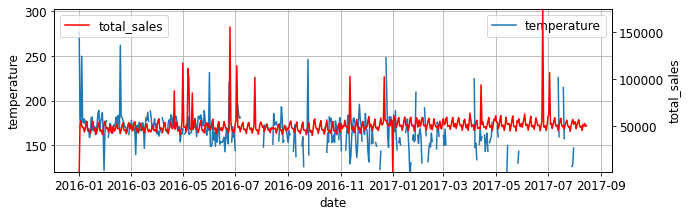

In [ ]:
x =  np.array(tem_sales.index.tolist())
y1 =  np.array(tem_sales.temperature.tolist())
y2 =  np.array(tem_sales.total_sales.tolist())

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y1, '-', label = 'temperature')
ax2 = ax.twinx()
ax2.plot(x, y2, '-r', label = 'total_sales')
ax.legend(loc=0)
ax.grid()
ax.set_xlabel('date')
ax.set_ylim(120,303)
ax.set_ylabel('temperature')
ax2.set_ylabel('total_sales')
ax2.set_ylim(841,174760)
ax2.legend(loc=2)
plt.rcParams['figure.figsize'] = (10,3)

In [ ]:
tem_sales.corr(method="pearson")

,temperature,total_sales
temperature,1.000000,-0.203589
total_sales,-0.203589,1.000000


In [ ]:
tem_sales['diff'] = tem_sales.temperature.diff(1)
tem_sales.head()

,temperature,total_sales,diff
date,,,
2016-01-01,277.000000,960.106445,NaN
2016-01-02,180.106079,51548.335938,-96.893921
2016-01-03,174.552185,55169.835938,-5.553894
2016-01-04,249.657394,49702.304688,75.105209
2016-01-05,177.575119,47880.910156,-72.082275


In [ ]:
tem_sales.corr(method="pearson")

,temperature,total_sales,diff
temperature,1.000000,-0.203589,0.540708
total_sales,-0.203589,1.000000,-0.045898
diff,0.540708,-0.045898,1.000000


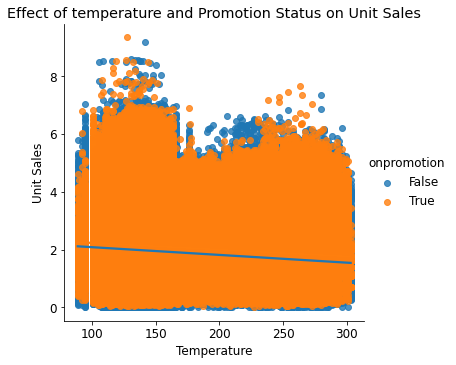

In [ ]:
plt.close('all')
sns.lmplot(data = train, x='temperature', y='unit_sales', hue='onpromotion')
plt.xlabel('Temperature')
plt.ylabel('Unit Sales')
plt.title('Effect of temperature and Promotion Status on Unit Sales')
plt.show()

### Sales & Day of week

In [ ]:
train['dayofweek']=train['date'].dt.dayofweek
day_sales=train[['Month','dayofweek','unit_sales']].groupby(['dayofweek','Month'],as_index=False).agg({'unit_sales':'sum'})
day_sales=day_sales.rename(columns={"unit_sales": "total_sales"})

In [ ]:
day_sales

,dayofweek,Month,total_sales
0,0,April,377734.218750
1,0,August,335144.593750
2,0,December,199281.890625
3,0,February,427371.062500
4,0,January,446968.843750
...,...,...,...
79,6,March,441955.250000
80,6,May,612948.187500
81,6,November,224655.750000
82,6,October,275285.687500


In [ ]:
day_sales['Month'] = day_sales['Month'].astype('category')
day_sales['dayofweek'] = day_sales['dayofweek'].astype('category')
day_sales['month_dayofweek'] = day_sales['Month'].astype(str)+"-"+day_sales['dayofweek'].astype(str)

bars=alt.Chart(day_sales).mark_bar().encode(
    x='total_sales',
    y='Month',
    color=alt.Color('dayofweek',title='dayofweek'),
    tooltip=[alt.Tooltip('month_dayofweek:N'),
             alt.Tooltip('Month:N'),
             alt.Tooltip('total_sales:Q'),
            ]
    
).properties(
    width=600,
    height=400,
    title="Store sales of each state")

bars

alt.Chart(...)

By comparing the store sales of each day of the week in each month, it is obviously that consumers in Ecuador tend to spending more or visit stores more frequenctly during weekdays(dayofweek=5&6), followed by the sales of the beginning of week(Monday, Tuesday). The sales during the middle of week is the relatively lowest among all the stores and monthes.

In [ ]:
train['weekday'] = train['date'].map(lambda x: x.weekday())

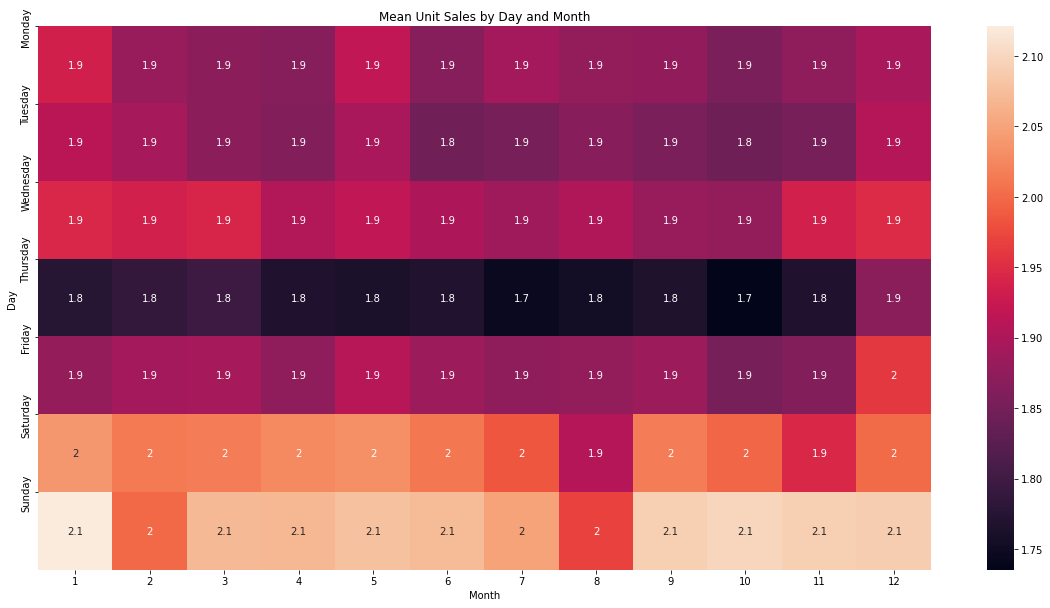

In [ ]:
time = train[['weekday','month','unit_sales']]
time = pd.pivot_table(time, values=['unit_sales'], index=['weekday'], columns=['month'], aggfunc=np.mean)
time = pd.DataFrame(time.to_records())
time.columns = [hdr.replace("('unit_sales', ","").replace(")", "") for hdr in time.columns]
time.drop('weekday', axis=1, inplace=True)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.close('all')
plt.figure(figsize=(20,10))
sns.heatmap(time, annot=True)
labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.yticks(time.index.values, labels)
plt.ylabel('Day')
plt.xlabel('Month')
plt.title('Mean Unit Sales by Day and Month')
plt.show()

The lighter, the higher mean unit sales. 
It is obvious that more itmes were purchased in larger quantities on weekends and during the month of December

In [ ]:
train

,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,type,cluster,oil_price,dayofweek,day_type,locale,locale_name,description,transferred,transactions,temperature,year,month,day
0,2016-01-01,25,108701,1.098633,True,DELI,2644,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,277.0,2016,1,1
1,2016-01-01,25,123347,3.433594,False,DAIRY,2114,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,277.0,2016,1,1
2,2016-01-01,25,127547,1.386719,True,EGGS,2502,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,277.0,2016,1,1
3,2016-01-01,25,129635,3.611328,False,DAIRY,2112,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,277.0,2016,1,1
4,2016-01-01,25,153239,2.708984,False,BREAD/BAKERY,2712,1,Salinas,Santa Elena,D,1,NaN,4.0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,277.0,2016,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15589329,2017-08-15,54,2081056,0.693359,False,PREPARED FOODS,2986,1,El Carmen,Manabi,C,3,47.57,1.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,802.0,NaN,2017,8,15
15589330,2017-08-15,54,2081064,3.912109,False,PREPARED FOODS,2966,1,El Carmen,Manabi,C,3,47.57,1.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,802.0,NaN,2017,8,15
15589331,2017-08-15,54,2081095,1.386719,False,PREPARED FOODS,2962,1,El Carmen,Manabi,C,3,47.57,1.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,802.0,NaN,2017,8,15
15589332,2017-08-15,54,2081161,3.738281,False,PREPARED FOODS,2966,1,El Carmen,Manabi,C,3,47.57,1.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,802.0,NaN,2017,8,15


### Sales & Product Family

In [ ]:
encoder = LabelEncoder()
train['onpromotion'] = encoder.fit_transform(train['onpromotion'].values)
train.head()

In [ ]:
family = train[['family','unit_sales']]

In [ ]:
domain = ['BREAD/BAKERY', 'DELI', 'DAIRY', 'EGGS', 'POULTRY', 'MEATS','SEAFOOD', 'PRODUCE', 'PREPARED FOODS']
range_ = ['green','orange','gray','salmon,','blue','purple','black','brown','pink']
alt.Chart(family.sample(5000)).mark_boxplot().encode(
    alt.X('family:O',sort=['BREAD/BAKERY', 'DELI', 'DAIRY', 'EGGS', 'POULTRY', 'MEATS','SEAFOOD', 'PRODUCE', 'PREPARED FOODS']),
    alt.Y('unit_sales:Q',title="Unit Sales under each product family"),
    color=alt.Color('family', scale=alt.Scale(domain=domain, range=range_)),
    tooltip=[alt.Tooltip('family:O'),
            alt.Tooltip('unit_sales')]
).configure_mark().properties(width=600,height=400,title="Unit Sales vs Product Family (Five point summary)")

alt.Chart(...)

the mean and lowest sales of different types of products are relatively stable, around 1.5 unit sales. 
However, the outlier of poultry and produce is much far deviated from the highest unit sales of these two types of products.

# Feature Engineering

##Preprocessing

Train: 2017.5.1-2017.7.1 --> 2017.7.1-7.3
Valid: 2017.5.5-2017.7.5 --> 2017.7.5-7.8
Test: 2017.5.9-2017.7.9 --> 2017.7.9-7.11

Before generating features,preprocessing have been done. 
Two tables,df_2017 and promo-_2017,that focusing on unit sales and weather promotion of each item of each store, have been generated. 

In [50]:
import gc
import numpy as np
import pandas as pd
import lightgbm as lgb
from time import time
from datetime import date, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [51]:
df_2017 = df_train[df_train['date'] >= '2017-01-01'] #filter the records of peroshable items after 2017-01-01

In [52]:
#encoder = LabelEncoder()

#items['family'] = encoder.fit_transform(items['family'].values)

#stores['city'] = encoder.fit_transform(stores['city'].values)
#stores['state'] = encoder.fit_transform(stores['state'].values)
#stores['type'] = encoder.fit_transform(stores['type'].values)

In [53]:
df_2017['unit_sales']=df_2017['unit_sales'].astype('float32')
#df_test['unit_sales']=df_test['unit_sales'].astype('float32')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Since the promotion information of target day have been provided, it is no longer the "unknown" informaiton. In this case, this feature could be concate with the "knowing" promoiton features. 

### Promotion

In [54]:
df_test=df_test.set_index(["store_nbr", "item_nbr", "date"])

In [55]:
#Since the promotion data of test dataset have been given, concat the information together
promo_2017_train = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)
del promo_2017_test, promo_2017_train
gc.collect()

0

In [56]:
# promotion table including trainding,valid and test dataset promotion informaiton
promo_2017.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         103665         False       False       False       False   
          108696         False       False       False       False   
          108698         False       False       False       False   
          108701         False       False       False       False   
          108831         False       False       False       False   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         103665         False       False       False       False   
          108696         False       False       False       False   
          108698         False        True       False       False   
          108701         False        True       False       False   
          108831         False       False       False       False   

date                2017-01-09  2017-01-10  2017-01-11  2017-01-12  \
store_nbr item_nbr                                                   
1         103665         False       False       False       False   
          108696          True        True        True        True   
          108698         False       False       False       False   
          108701         False       False        True        True   
          108831         False       False       False       False   

date                2017-01-13  2017-01-14  2017-01-15  2017-01-16  \
store_nbr item_nbr                                                   
1         103665         False       False       False       False   
          108696          True        True        True        True   
          108698          True       False       False       False   
          108701          True       False       False        True   
          108831         False       False       False       False   

date                2017-01-17  2017-01-18  2017-01-19  2017-01-20  \
store_nbr item_nbr                                                   
1         103665         False       False       False       False   
          108696          True        True        True        True   
          108698         False       False       False        True   
          108701         False        True       False        True   
          108831         False       False       False       False   

date                2017-01-21  2017-01-22  2017-01-23  2017-01-24  \
store_nbr item_nbr                                                   
1         103665         False       False       False       False   
          108696          True        True        True        True   
          108698         False       False       False       False   
          108701          True       False       False        True   
          108831         False       False       False       False   

date                2017-01-25  2017-01-26  2017-01-27  2017-01-28  \
store_nbr item_nbr                                                   
1         103665         False       False       False       False   
          108696          True        True        True       False   
          108698         False       False        True       False   
          108701          True        True        True       False   
          108831         False       False       False       False   

date                2017-01-29  2017-01-30  2017-01-31  2017-02-01  \
store_nbr item_nbr                                                   
1         103665         False       False       False       False   
          108696          True        True        True       False   
          108698         False       False       False       False   
          108701          True        True        True       False   
          108831         False       False       False       False   

date                2017-02-02  2017-02-03  2017-02-04  2017-02-05  \
st

###Weather

In [57]:
weather= weather[(weather.date>'2017-01-01')&(weather.date<'2017-08-15')]
weather=weather.groupby(['date','city'],as_index=False).agg({'temperature':'mean'})

In [58]:
a = df_2017.merge(store,on='store_nbr',how='left')
b = a.merge(weather,on=['date','city'],how='left')
b.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,temperature
0,2017-01-01,25,103665,2.080078,False,Salinas,Santa Elena,D,1,NaN
1,2017-01-01,25,108698,1.098633,False,Salinas,Santa Elena,D,1,NaN
2,2017-01-01,25,122095,0.693359,True,Salinas,Santa Elena,D,1,NaN
3,2017-01-01,25,123347,2.197266,False,Salinas,Santa Elena,D,1,NaN
4,2017-01-01,25,127547,1.386719,False,Salinas,Santa Elena,D,1,NaN


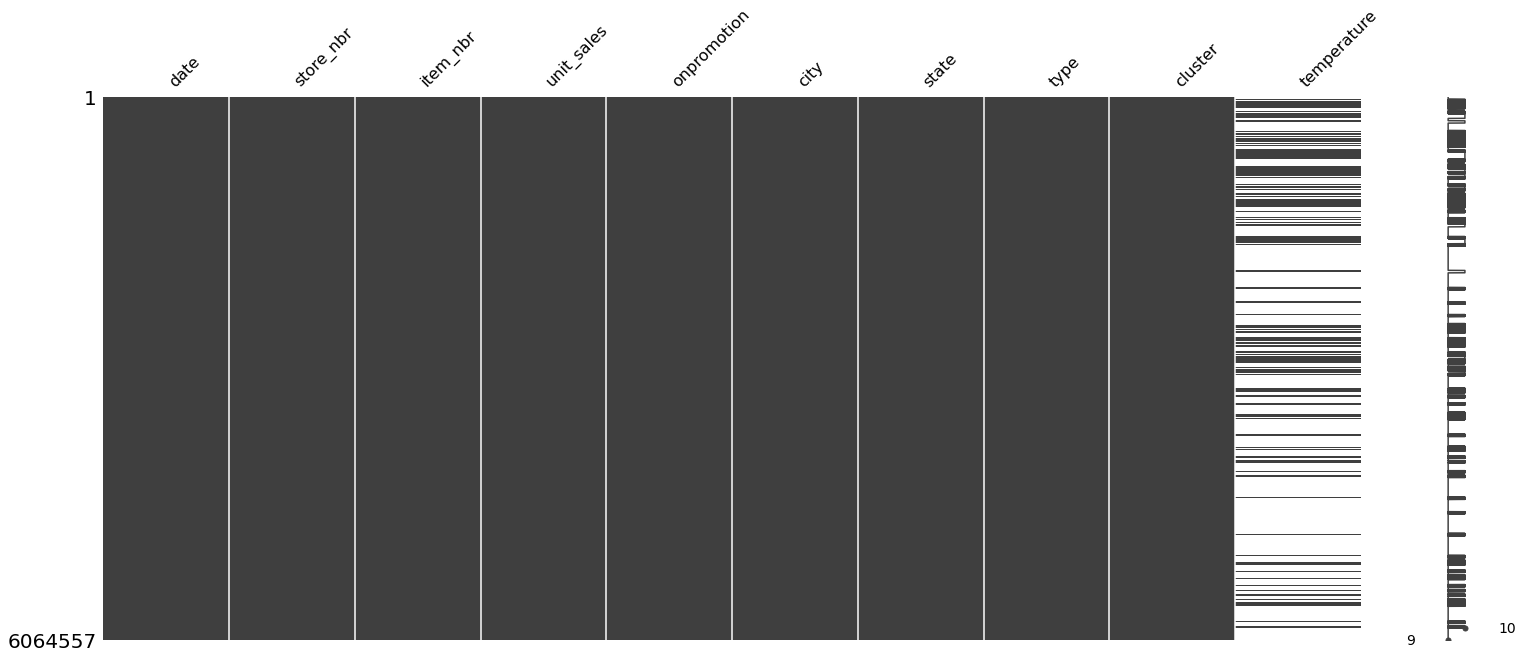

In [59]:
msno.matrix(b.sort_values('date'))

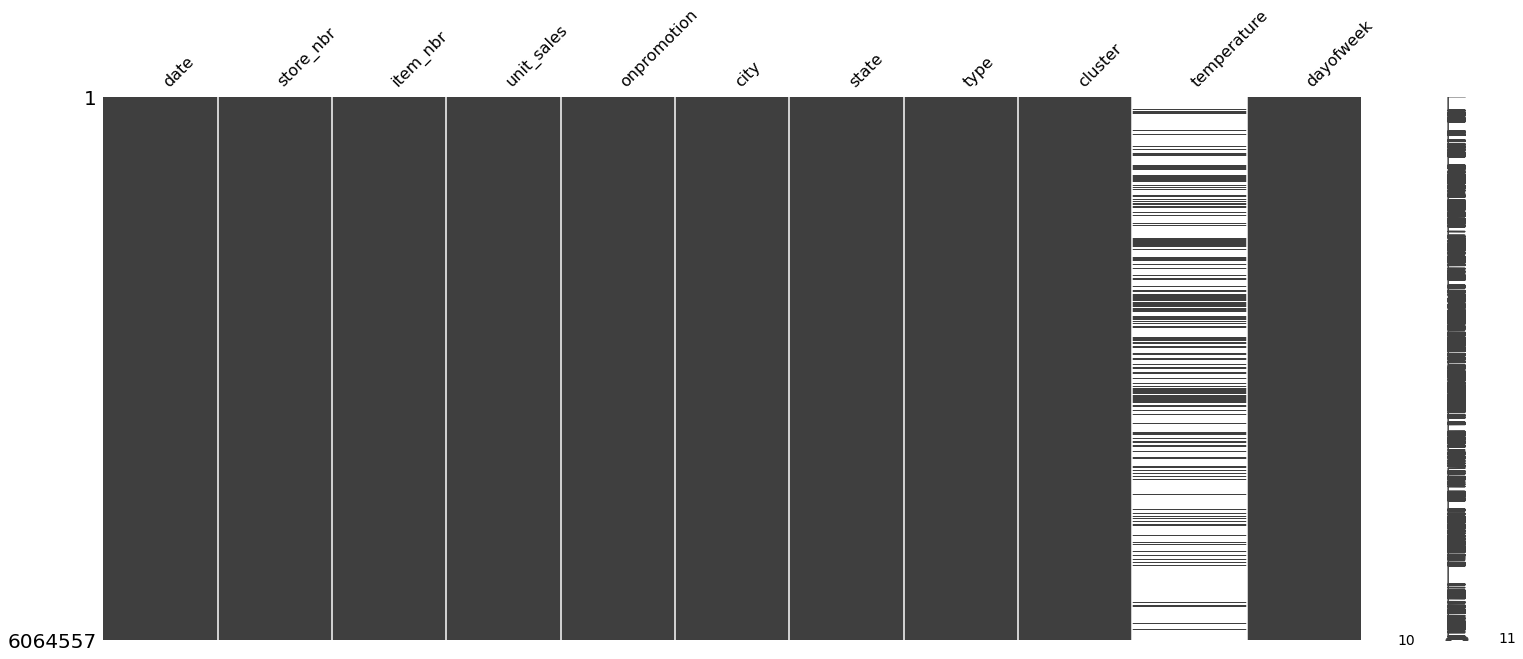

In [60]:
b['dayofweek'] = b.date.dt.dayofweek
msno.matrix(b.sort_values('dayofweek'))

In [61]:
def missing_values_table(df):
    mis_val = df.isnull().sum() 
    mis_val_percent = 100 * df.isnull().sum() / len(df)    # calculate the missing value percentage
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1) 
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0:'Missing Values',1:'% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values',ascending=False).round(1)    
    return mis_val_table_ren_columns

missing_values_table(b)

,Missing Values,% of Total Values
temperature,4275154,70.5


In [62]:
b.set_index(["store_nbr", "item_nbr", "date"])[["temperature"]].unstack(level=-1)

temperature                                              \
date                2017-01-01 2017-01-02 2017-01-03 2017-01-04 2017-01-05   
store_nbr item_nbr                                                           
1         103665           NaN        NaN        NaN      153.0      115.0   
          108696           NaN        NaN        NaN        NaN        NaN   
          108698           NaN        NaN      132.0      153.0        NaN   
          108701           NaN        NaN      132.0      153.0      115.0   
          108831           NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
54        2081161          NaN        NaN        NaN        NaN        NaN   
          2086882          NaN        NaN        NaN        NaN        NaN   
          2087374          NaN        NaN        NaN        NaN        NaN   
          2087543          NaN        NaN        NaN        NaN        NaN   
          2087567          NaN        NaN        NaN        NaN        NaN   

                                                                           \
date               2017-01-06 2017-01-07 2017-01-08 2017-01-09 2017-01-10   
store_nbr item_nbr                                                          
1         103665        116.0        NaN      139.0        NaN      114.0   
          108696          NaN        NaN        NaN      129.0      114.0   
          108698        116.0        NaN        NaN      129.0      114.0   
          108701        116.0        NaN        NaN        NaN        NaN   
          108831          NaN        NaN        NaN        NaN        NaN   
...                       ...        ...        ...        ...        ...   
54        2081161         NaN        NaN        NaN        NaN        NaN   
          2086882         NaN        NaN        NaN        NaN        NaN   
          2087374         NaN        NaN        NaN        NaN        NaN   
          2087543         NaN        NaN        NaN        NaN        NaN   
          2087567         NaN        NaN        NaN        NaN        NaN   

                                                                           \
date               2017-01-11 2017-01-12 2017-01-13 2017-01-14 2017-01-15   
store_nbr item_nbr                                                          
1         103665          NaN      123.0        NaN        NaN        NaN   
          108696          NaN      123.0        NaN        NaN        NaN   
          108698          NaN      123.0        NaN        NaN        NaN   
          108701          NaN      123.0        NaN        NaN        NaN   
          108831          NaN        NaN        NaN        NaN        NaN   
...                       ...        ...        ...        ...        ...   
54        2081161         NaN        NaN        NaN        NaN        NaN   
          2086882         NaN        NaN        NaN        NaN        NaN   
          2087374         NaN        NaN        NaN        NaN        NaN   
          2087543         NaN        NaN        NaN        NaN        NaN   
          2087567         NaN        NaN        NaN        NaN        NaN   

                                                                           \
date               2017-01-16 2017-01-17 2017-01-18 2017-01-19 2017-01-20   
store_nbr item_nbr                                                          
1         103665        133.0      148.0      138.0      136.0      110.0   
          108696        133.0      148.0      138.0      136.0      110.0   
          108698        133.0      148.0      138.0        NaN      110.0   
          108701        133.0        NaN      138.0        NaN      110.0   
          108831          NaN        NaN        NaN        NaN        NaN   
...                       ...        ...        ...        ...        ...   
54        2081161         NaN        NaN        NaN        NaN        NaN  

Based on the missing value matrix, there is no direct correlation between the missing of temperature with date or dayofweek. In addition,since the temperature dataset is outsourced, there is no uncovered pattern of missing values. In this case, it is reasonable to interprate that the pattern of temperature missing is completely at random, and therefore it will not influence the distribution of target value. 
Furthermore,since the percentage of missing value is alsomost equal to 70%, missing value imputaiton may bring more noise instead. 

In conclusion, temperature will not be included as a feature in this research.

### Oil

In [63]:
a = df_2017.merge(oil,on='date',how='left')

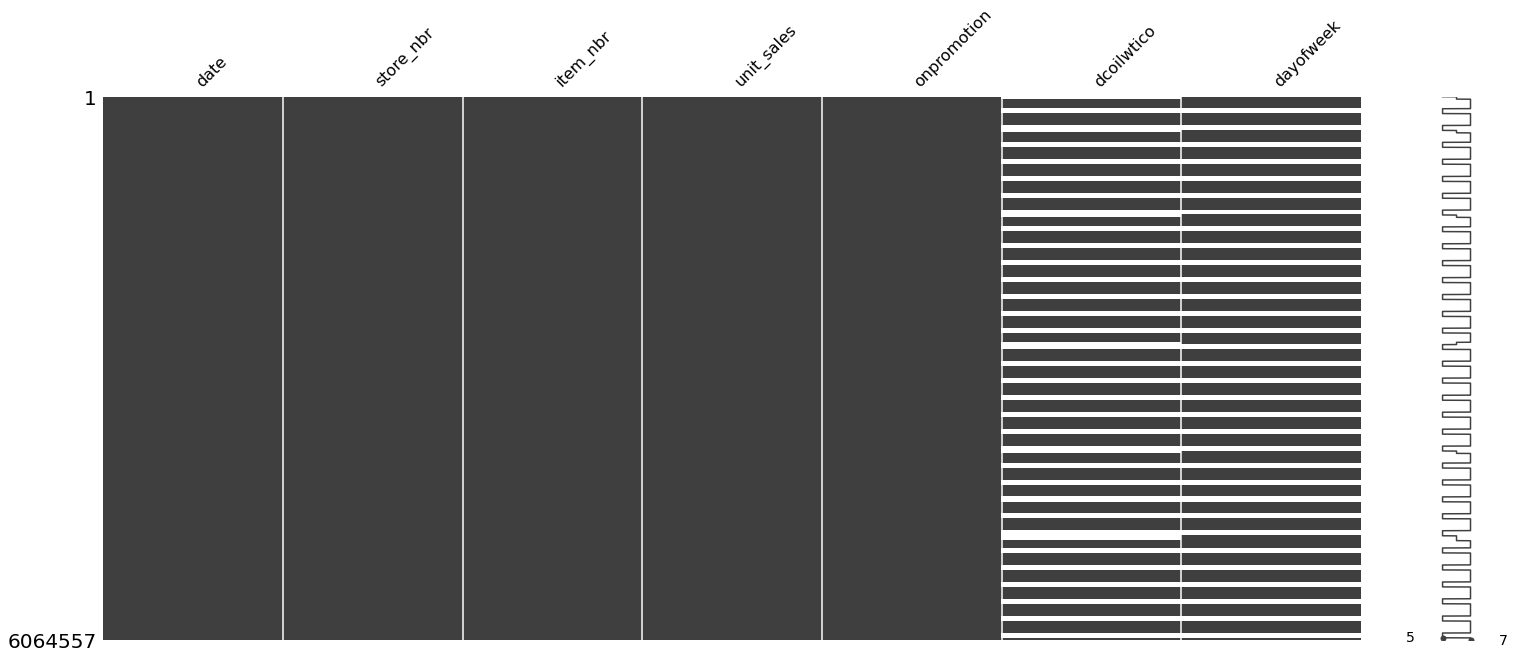

In [64]:
msno.matrix(a.sort_values('date'))

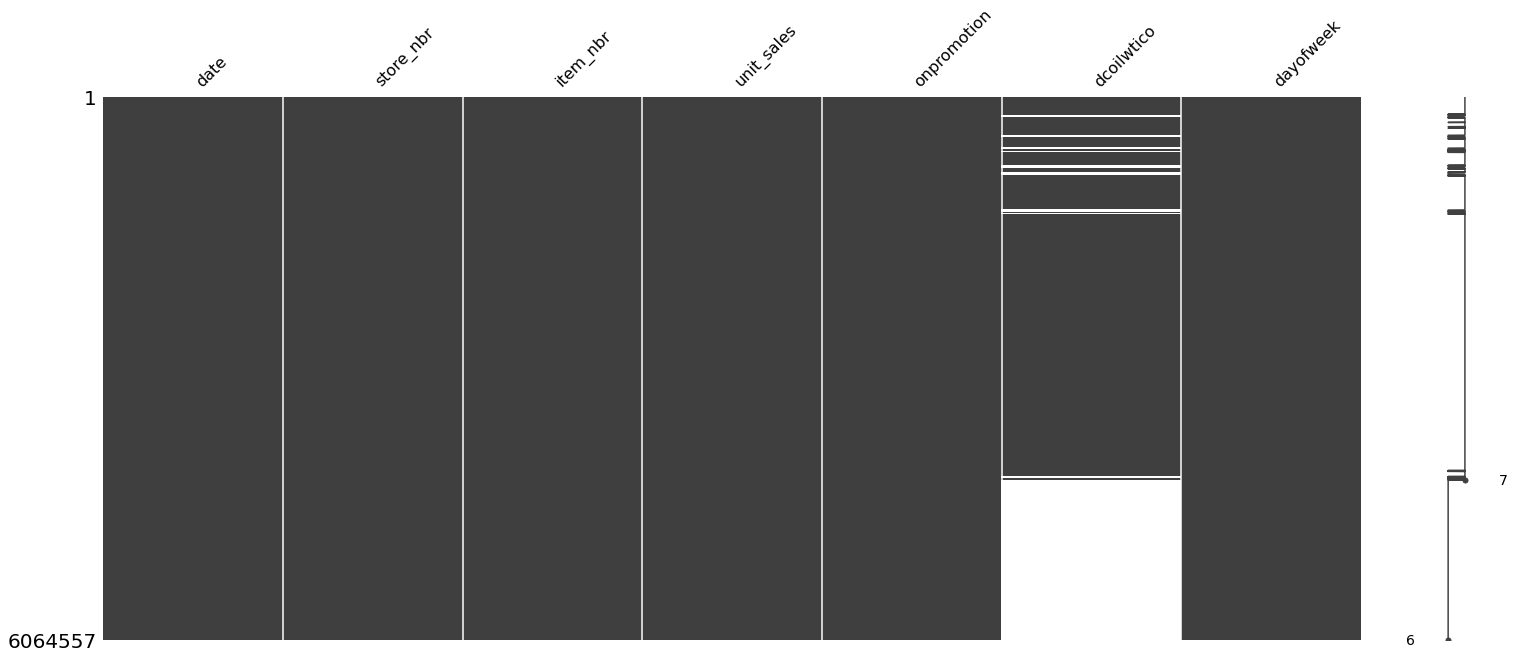

In [65]:
a['dayofweek'] = a.date.dt.dayofweek
msno.matrix(a.sort_values('dayofweek'))

In [66]:
def missing_values_table(df):
    mis_val = df.isnull().sum() 
    mis_val_percent = 100 * df.isnull().sum() / len(df)    # calculate the missing value percentage
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1) 
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0:'Missing Values',1:'% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values',ascending=False).round(1)    
    return mis_val_table_ren_columns

missing_values_table(a)

,Missing Values,% of Total Values
dcoilwtico,1976024,32.6


According to the missing matrix, it is obvious that there is a direct correlation between dayofweek and missing oil price,which is missing not at random.Since there is a sprcific missing pattern and the percentage of missing value of around 30%, oil price will be imputed. 

It is known to all that the price of oil is not pubilshed during the weekends,therefore, the imputation methods are pretty intuiation, one is remain the friday price, and another one is the use linear interplote methods to fit the friday price and next monday price. 

####Missing Value Imputation

#####Last Price remaining

In [67]:
a.fillna(method='ffill',inplace=True)
missing_values_table(a)

,Missing Values,% of Total Values
dcoilwtico,28141,0.5


In [68]:
# as the date of missing value are 2017-01-01 and 2017-01-02, which will not have influence on the model trainding, 
# Therefore, the missing value will not be imputated. 
a[a.dcoilwtico.isnull()]

,date,store_nbr,item_nbr,unit_sales,onpromotion,dcoilwtico,dayofweek
0,2017-01-01,25,103665,2.080078,False,NaN,6
1,2017-01-01,25,108698,1.098633,False,NaN,6
2,2017-01-01,25,122095,0.693359,True,NaN,6
3,2017-01-01,25,123347,2.197266,False,NaN,6
4,2017-01-01,25,127547,1.386719,False,NaN,6
...,...,...,...,...,...,...,...
28136,2017-01-02,54,2009639,0.693359,False,NaN,0
28137,2017-01-02,54,2027827,0.693359,False,NaN,0
28138,2017-01-02,54,2028435,1.609375,False,NaN,0
28139,2017-01-02,54,2036460,1.386719,False,NaN,0


In [69]:
oil_2017 = a.groupby(["date"]).agg({'dcoilwtico':'mean'}).T
oil_2017

date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-15,2017-01-16,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-21,2017-01-22,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-28,2017-01-29,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-04,2017-02-05,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-11,2017-02-12,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-18,2017-02-19,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-11,2017-03-12,2017-03-13,2017-03-14,2017-03-15,2017-03-16,2017-03-17,2017-03-18,2017-03-19,2017-03-20,2017-03-21,2017-03-22,2017-03-23,2017-03-24,2017-03-25,2017-03-26,2017-03-27,2017-03-28,2017-03-29,2017-03-30,2017-03-31,2017-04-01,2017-04-02,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09,2017-04-10,2017-04-11,2017-04-12,2017-04-13,2017-04-14,2017-04-15,2017-04-16,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22,2017-04-23,2017-04-24,2017-04-25,2017-04-26,2017-04-27,2017-04-28,2017-04-29,2017-04-30,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-06,2017-05-07,2017-05-08,2017-05-09,2017-05-10,2017-05-11,2017-05-12,2017-05-13,2017-05-14,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,2017-05-20,2017-05-21,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,2017-06-11,2017-06-12,2017-06-13,2017-06-14,2017-06-15,2017-06-16,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,2017-07-11,2017-07-12,2017-07-13,2017-07-14,2017-07-15,2017-07-16,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-28,2017-07-29,2017-07-30,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14
dcoilwtico,NaN,NaN,52.36,53.26,53.77,53.98,53.98,53.98,51.95,50.82,52.19,53.01,52.36,52.36,52.36,52.36,52.45,51.12,51.39,52.33,52.33,52.33,52.77,52.38,52.14,53.24,53.18,53.18,53.18,52.63,52.75,53.9,53.55,53.81,53.81,53.81,53.01,52.19,52.37,52.99,53.84,53.84,53.84,52.96,53.21,53.11,53.41,53.41,53.41,53.41,53.41,54.02,53.61,54.48,53.99,53.99,53.99,54.04,54.0,53.82,52.63,53.33,53.33,53.33,53.19,52.68,49.83,48.75,48.05,48.05,48.05,47.95,47.24,48.34,48.3,48.34,48.34,48.34,47.79,47.02,47.29,47.0,47.3,47.3,47.3,47.02,48.36,49.47,50.3,50.54,50.54,50.54,50.25,50.99,51.14,51.69,52.25,52.25,52.25,53.06,53.38,53.12,53.19,53.19,53.19,53.19,52.62,52.46,50.49,50.26,49.64,49.64,49.64,48.9,49.22,49.22,48.96,49.31,49.31,49.31,48.83,47.65,47.79,45.55,46.23,46.23,46.23,46.46,45.84,47.28,47.81,47.83,47.83,47.83,48.86,48.64,49.04,49.36,50.32,50.32,50.32,50.81,51.12,50.99,48.57,49.58,49.58,49.58,49.58,49.63,48.29,48.32,47.68,47.68,47.68,47.4,48.13,45.8,45.68,45.82,45.82,45.82,46.1,46.41,44.79,44.47,44.73,44.73,44.73,44.24,43.34,42.48,42.53,42.86,42.86,42.86,43.24,44.25,44.74,44.88,46.02,46.02,46.02,46.02,46.02,45.11,45.52,44.25,44.25,44.25,44.4,45.06,45.48,46.06,46.53,46.53,46.53,46.02,46.4,47.1,46.73,45.78,45.78,45.78,46.21,47.77,48.58,49.05,49.72,49.72,49.72,50.21,49.19,49.6,49.03,49.57,49.57,49.57,49.37,49.07,49.59,48.54,48.81,48.81,48.81,47.59


### Unit sales

In [70]:
df_2017['unit_sales'] = df_2017['unit_sales'].astype('float32')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
df_2017 = df_2017.set_index(["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

##Feature Generate

Based on the two tables generated before, features have been generated deriated from two tables. 

In [72]:
def get_timespan(df, dt, minus, periods,freq='D'): 
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods,freq=freq)]

In [73]:
def add_TS_features(df_2017,promo_2017,oil_2017,t2017,is_train=True,name_prefix=None): # total 54 features
    X = pd.DataFrame({#totally 5 features
        "store_nbr":df_2017.index.get_level_values(0), 
        "item_nbr":df_2017.index.get_level_values(1),
    })
    #Comparison between sales and promotion(12 features)
    for i in [3,7,14,30,60,90]:
        tmp1 = get_timespan(df_2017, t2017, i, i)  #sales of each store i days before
        tmp2 = (get_timespan(promo_2017, t2017, i, i) > 0) * 1  #whether on promotion of each store i days before
        X['has_promo_mean_%s' % i] = (tmp1 * tmp2.replace(0, np.nan)).mean(axis=1).values  # mean sales of each store with promotion
        X['no_promo_mean_%s' % i] = (tmp1 * (1 - tmp2).replace(0, np.nan)).mean(axis=1).values  # mean sales of each store without promotion

    #Basic statistical sales data (36 features)
    for i in [3,7,14,30,60,90]:
        tmp = get_timespan(df_2017, t2017, i, i) 
        X['diff_%s_mean' % i] = tmp.diff(axis=1).mean(axis=1).values  # diff(1) of means sales in each store i days before 
        X['mean_%s' % i] = tmp.mean(axis=1).values  # mean sales of each store i days before 
        X['median_%s' % i] = tmp.median(axis=1).values  # median
        X['min_%s' % i] = tmp.min(axis=1).values  # min sales 
        X['max_%s' % i] = tmp.max(axis=1).values  # max sales
        X['std_%s' % i] = tmp.std(axis=1).values
    #Sales(16 features)
    for i in [3,7,14,30,60,90]: 
        tmp = get_timespan(df_2017, t2017, i, i)  # sales of each store 
        X['has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values  # count of days with sales of eahc store
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values  # gap since last day have sales
        X['first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values  # the day first have sales
   #Promotion(18 features)    
        tmp = get_timespan(promo_2017, t2017, i, i)  
        X['has_promo_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values  # count of days with promotion
        X['last_has_promo_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values  # gap since last day with sales 
        X['first_has_promo_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values  # the day first in promoti
   #Oil price(12 features)
    for i in [3,7,14,30,60,90]: # total 12 features
        tmp = get_timespan(oil_2017,t2017, i, i) 
        value = tmp.mean(axis=1).values
        value=value.astype('float32')
        X['oilmean_%s' % i] = np.full([37190,1],value) #get the mean oil price i days before
        value2=tmp.diff(axis=1).mean(axis=1).values
        values2 = value2.astype('float32')
        X['oil_diff_%s_mean' % i] = np.full([37190,1],value2) #get thet diff(1) of oil price i days before 
    
  #Promotion of predict day (1 feature) 
    X["promo_{}".format(1)] = promo_2017[pd.to_datetime(str(t2017))].values.astype(np.uint8)
    X = pd.DataFrame(X)
    X.fillna(0,inplace=True) #as some items have not been promoted will not have promote sales, these null value will be replaced by 0 
  #Get target value
    if is_train:
        y = df_2017[pd.date_range(t2017, periods=1)].values 
        return X, y
        
    return X

In [74]:
X_train, y_train = add_TS_features(df_2017,promo_2017,oil_2017,date(2017,7,31))
X_val, y_val = add_TS_features(df_2017,promo_2017,oil_2017,date(2017,8,7))
X_test,y_test = add_TS_features(df_2017,promo_2017,oil_2017,date(2017,8,14))

In [75]:
X_train

,store_nbr,item_nbr,has_promo_mean_3,no_promo_mean_3,has_promo_mean_7,no_promo_mean_7,has_promo_mean_14,no_promo_mean_14,has_promo_mean_30,no_promo_mean_30,has_promo_mean_60,no_promo_mean_60,has_promo_mean_90,no_promo_mean_90,diff_3_mean,mean_3,median_3,min_3,max_3,std_3,diff_7_mean,mean_7,median_7,min_7,max_7,std_7,diff_14_mean,mean_14,median_14,min_14,max_14,std_14,diff_30_mean,mean_30,median_30,min_30,max_30,std_30,diff_60_mean,mean_60,median_60,min_60,max_60,std_60,diff_90_mean,mean_90,median_90,min_90,max_90,std_90,has_sales_days_in_last_3,last_has_sales_day_in_last_3,first_has_sales_day_in_last_3,has_promo_days_in_last_3,last_has_promo_day_in_last_3,first_has_promo_day_in_last_3,has_sales_days_in_last_7,last_has_sales_day_in_last_7,first_has_sales_day_in_last_7,has_promo_days_in_last_7,last_has_promo_day_in_last_7,first_has_promo_day_in_last_7,has_sales_days_in_last_14,last_has_sales_day_in_last_14,first_has_sales_day_in_last_14,has_promo_days_in_last_14,last_has_promo_day_in_last_14,first_has_promo_day_in_last_14,has_sales_days_in_last_30,last_has_sales_day_in_last_30,first_has_sales_day_in_last_30,has_promo_days_in_last_30,last_has_promo_day_in_last_30,first_has_promo_day_in_last_30,has_sales_days_in_last_60,last_has_sales_day_in_last_60,first_has_sales_day_in_last_60,has_promo_days_in_last_60,last_has_promo_day_in_last_60,first_has_promo_day_in_last_60,has_sales_days_in_last_90,last_has_sales_day_in_last_90,first_has_sales_day_in_last_90,has_promo_days_in_last_90,last_has_promo_day_in_last_90,first_has_promo_day_in_last_90,oilmean_3,oil_diff_3_mean,oilmean_7,oil_diff_7_mean,oilmean_14,oil_diff_14_mean,oilmean_30,oil_diff_30_mean,oilmean_60,oil_diff_60_mean,oilmean_90,oil_diff_90_mean,promo_1
0,1,103665,0.000000,1.268880,0.000000,1.201730,0.000000,0.955915,0.000000,0.971484,0.000000,1.041602,0.000000,1.037706,0.000000,1.268880,1.098633,1.098633,1.609375,0.294877,-0.085124,1.201730,1.386719,0.000000,1.609375,0.577084,0.084510,0.955915,1.098633,0.000000,1.791992,0.687043,-0.047784,0.971484,1.098633,0.000000,2.484375,0.770602,0.018621,1.041602,1.098633,0.0,2.484375,0.712310,0.004554,1.037706,1.098633,0.0,2.484375,0.710420,3,1,3,0,3,0,6,1,7,0,7,0,10,1,13,0,14,0,21,1,30,0,30,0,46,1,59,0,60,0,69,1,90,0,90,0,49.720001,0.0,48.681427,0.585,47.454285,0.284615,46.413666,0.127586,45.808334,0.023729,46.707222,0.023258,0
1,1,108696,0.000000,0.231120,0.000000,0.328962,1.098633,0.567608,0.895996,0.558350,1.070871,0.738023,1.147372,0.856112,0.346680,0.231120,0.000000,0.000000,0.693359,0.400311,-0.152669,0.328962,0.000000,0.000000,1.609375,0.620930,0.000000,0.605538,0.693359,0.000000,1.609375,0.626325,0.023909,0.580859,0.693359,0.000000,1.609375,0.591842,-0.006869,0.776855,0.693359,0.0,1.609375,0.582793,-0.007791,0.891710,1.098633,0.0,1.946289,0.615079,1,1,1,0,3,0,2,1,7,0,7,0,8,1,14,1,10,10,17,1,29,2,10,17,43,1,60,7,10,59,68,1,90,11,10,87,49.720001,0.0,48.681427,0.585,47.454285,0.284615,46.413666,0.127586,45.808334,0.023729,46.707222,0.023258,0
2,1,108698,0.693359,0.000000,0.693359,0.462240,1.040039,0.611572,1.069336,0.891038,1.245660,0.974322,1.284029,0.996271,-0.346680,0.231120,0.000000,0.000000,0.693359,0.400311,-0.231120,0.495257,0.693359,0.000000,1.386719,0.524130,-0.137846,0.672782,0.693359,0.000000,1.791992,0.623084,-0.047818,0.914811,1.098633,0.000000,1.791992,0.579634,-0.023504,1.015023,1.098633,0.0,2.080078,0.571496,-0.018083,1.037836,1.098633,0.0,2.080078,0.580986,1,3,3,1,3,3,4,3,7,1,3,3,9,3,14,2,3,10,24,3,30,4,3,24,51,3,60,9,3,59,77,3,90,13,3,87,49.720001,0.0,48.681427,0.585,47.454285,0.284615,46.413666,0.127586,45.808334,0.023729,46.707222,0.023258,0
3,1,108701,2.398438,0.000000,1.892578,0.277344,1.492839,0.378196,1.394287,0.461914,1.331665,0.517503,1.089233,0.472538,-1.199219,0.799479,0.000000,0.000000,2.398438,1.384739,-0.115560,0.738839,0.693359,0.000000,2.398438,0.895898,0.000000,0.617048,0.346680,0.000000,2.398438,0.766271,0.000000,0.586230,0.693359,0.000000,2.398438,0.636234,0.000000,0.626058,0.693359,0.0,2.398438,0.5

##Feature Selection

###Random Forest

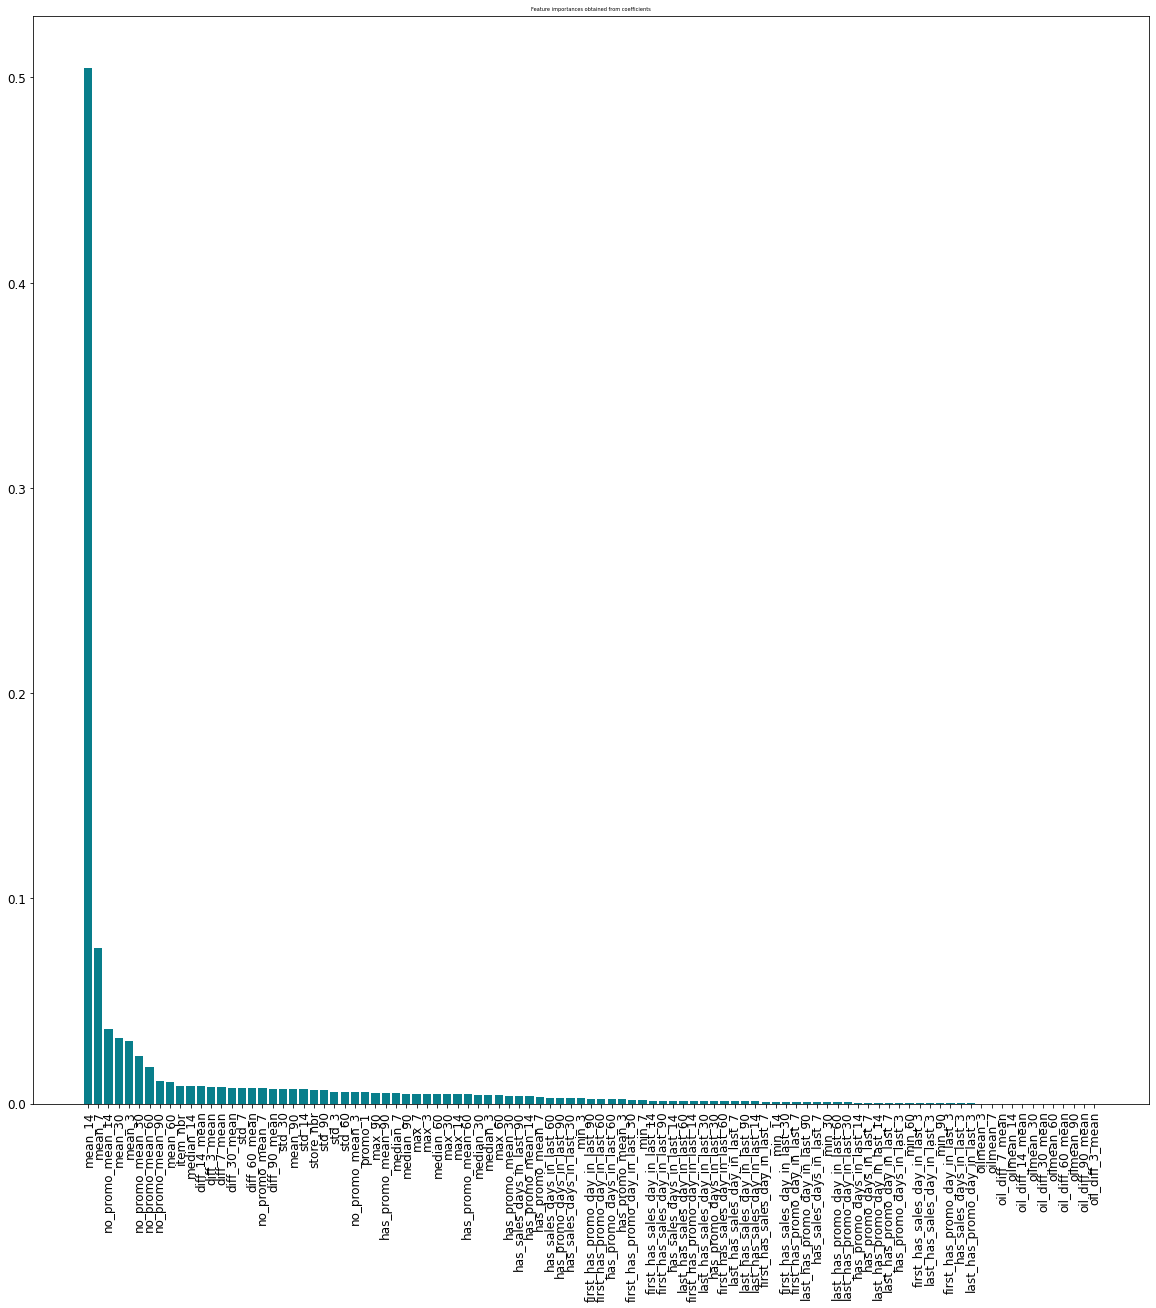

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
X_train_scaled = MinMaxScaler().fit_transform(X_train)

model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled,y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,           
    'Importance': model.feature_importances_
})
importances=importances.sort_values(by='Importance',ascending=False)   #sort the features based on the importance 

plt.bar(x=importances['Attribute'],height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=5)
plt.xticks(rotation='vertical')
plt.show()
rf=importances.iloc[0:30,:]
plt.rcParams['figure.figsize'] = (20.0, 20.0)

###GenericUnivariateSelect

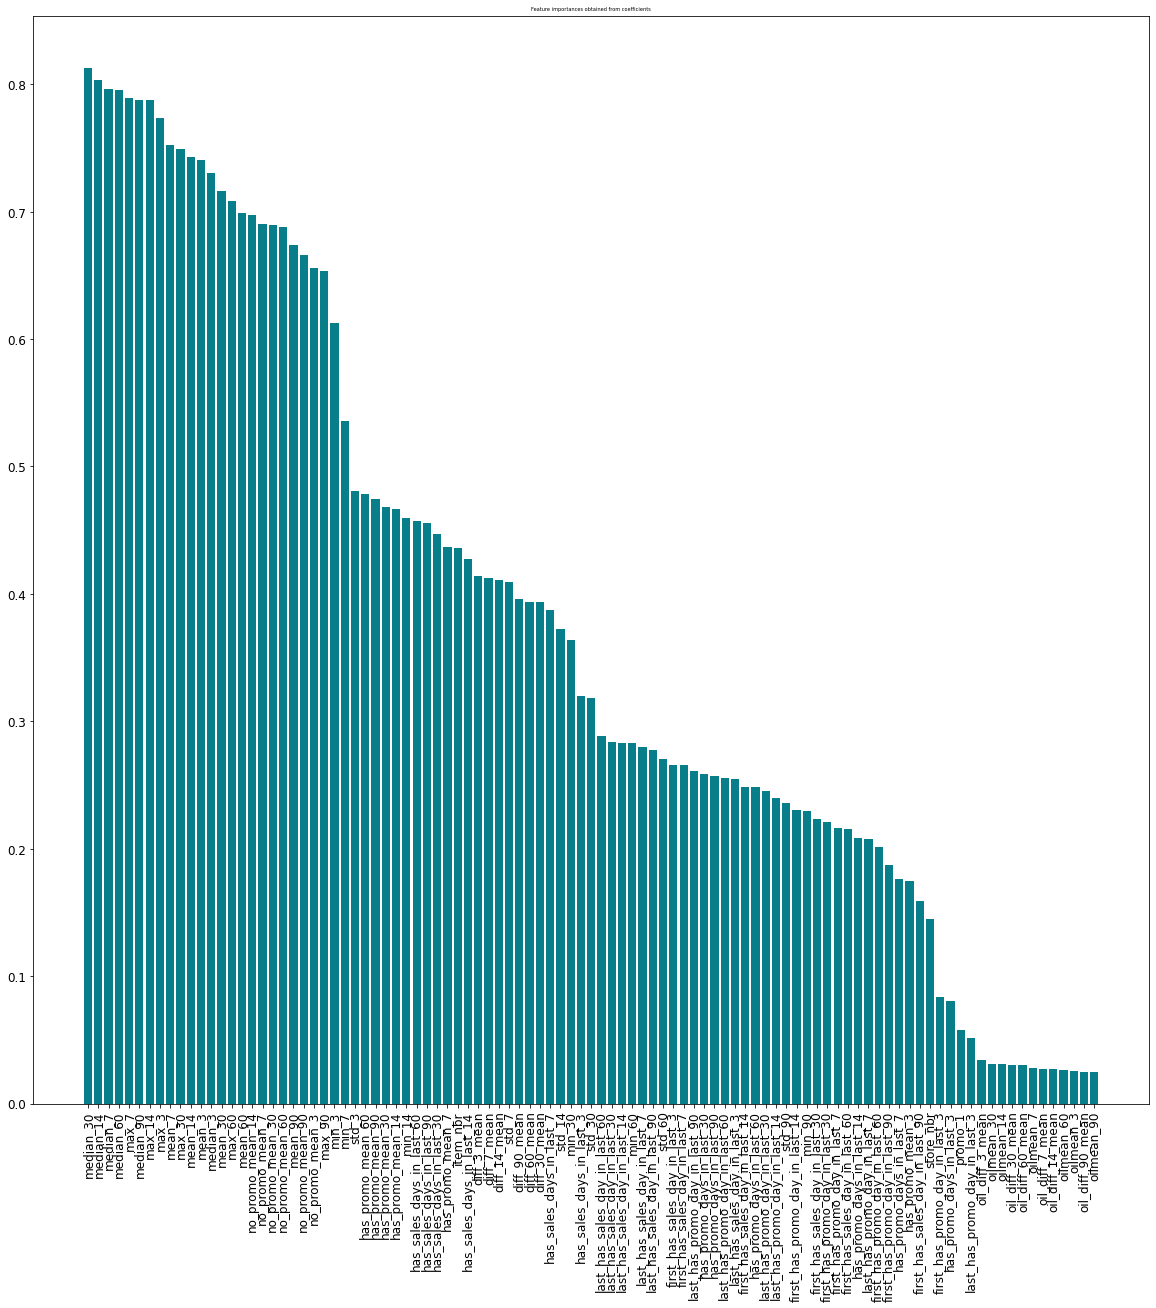

In [89]:
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import mutual_info_regression 
X_train_scaled = MinMaxScaler().fit_transform(X_train)

model = GenericUnivariateSelect(score_func=mutual_info_regression, mode='k_best', param=30)
model.fit(X_train_scaled,y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.scores_
})
importances=importances.sort_values(by='Importance',ascending=False)

plt.bar(x=importances['Attribute'],height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=5)
plt.xticks(rotation='vertical')
plt.show()
us=importances.iloc[0:30,:]
plt.rcParams['figure.figsize'] = (20.0, 20.0)

In [78]:
#combine the feature selected by three models 
all = pd.concat([rf,us],axis=1)
features = all.iloc[:,[0,2]]
features.columns=['rf','us']

In [79]:
count = []
for column in features.columns:
  for i in features[str(column)]:
    count.append(i)

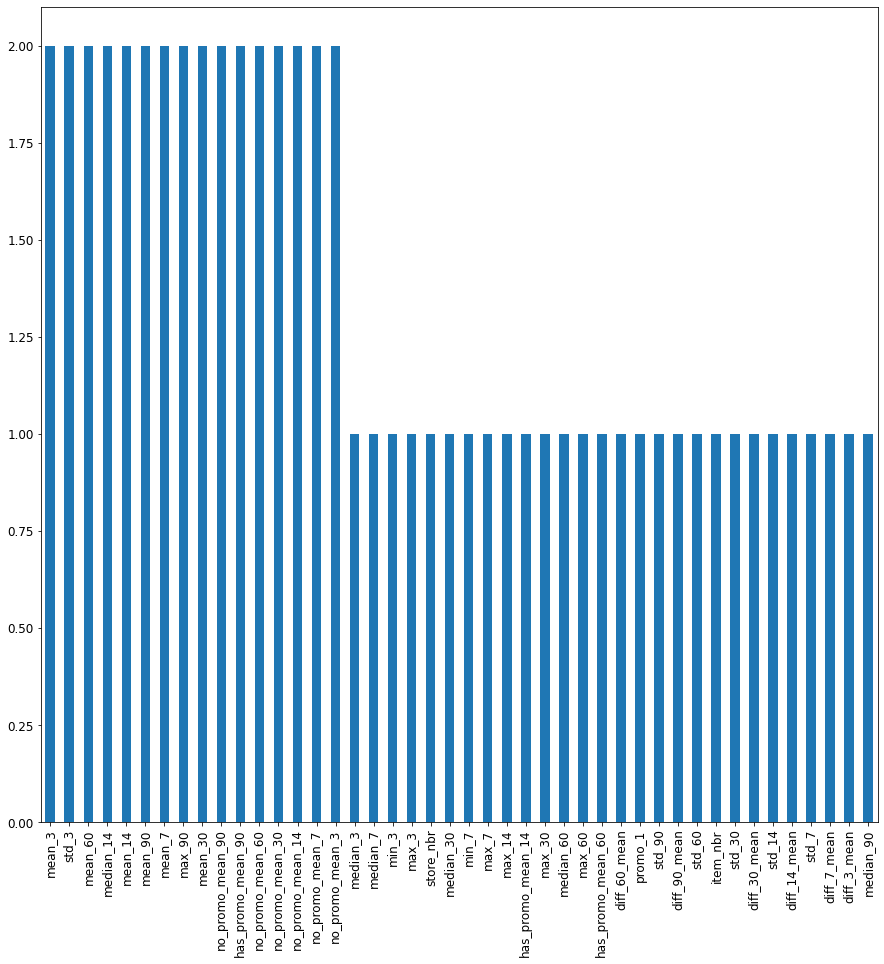

In [80]:
#Selected features presentation
result = pd.value_counts(count)
result.plot.bar()
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [81]:
selected_features = result.index.to_list()
selected_features

['mean_3',
 'std_3',
 'mean_60',
 'median_14',
 'mean_14',
 'mean_90',
 'mean_7',
 'max_90',
 'mean_30',
 'no_promo_mean_90',
 'has_promo_mean_90',
 'no_promo_mean_60',
 'no_promo_mean_30',
 'no_promo_mean_14',
 'no_promo_mean_7',
 'no_promo_mean_3',
 'median_3',
 'median_7',
 'min_3',
 'max_3',
 'store_nbr',
 'median_30',
 'min_7',
 'max_7',
 'max_14',
 'has_promo_mean_14',
 'max_30',
 'median_60',
 'max_60',
 'has_promo_mean_60',
 'diff_60_mean',
 'promo_1',
 'std_90',
 'diff_90_mean',
 'std_60',
 'item_nbr',
 'std_30',
 'diff_30_mean',
 'std_14',
 'diff_14_mean',
 'std_7',
 'diff_7_mean',
 'diff_3_mean',
 'median_90']

In [82]:
count = []
for i in selected_features:
    count.append(i.split('_')[0:2])
counts = pd.DataFrame(count)
counts.value_counts()

0       1    
no      promo    6
has     promo    3
diff    14       1
median  3        1
        30       1
        60       1
        7        1
        90       1
min     3        1
        7        1
promo   1        1
mean    90       1
std     14       1
        3        1
        30       1
        60       1
        7        1
        90       1
median  14       1
mean    7        1
diff    3        1
max     3        1
diff    30       1
        60       1
        7        1
        90       1
item    nbr      1
max     14       1
        30       1
mean    60       1
max     60       1
        7        1
        90       1
mean    14       1
        3        1
        30       1
store   nbr      1
dtype: int64

After feature selection, 105 features have been dowsized to 44 features.
By ignoring the Suffix of each feature, it have been found that sales correlated features(diff,max,mean, median,std) have the highest vote, followed by promotion-related features(first_has_promo_day_in_last_14,promo_2) 

In [106]:
X_train_scaled = X_train[selected_features]
X_val_scaled = X_val[selected_features]
X_test_scaled = X_test[selected_features]

In [84]:
from sklearn.preprocessing import StandardScaler
X_train_scaled = StandardScaler().fit_transform(X_train_scaled)
X_val_scaled = StandardScaler().fit_transform(X_val_scaled)
X_test_scaled = StandardScaler().fit_transform(X_test_scaled)

In [107]:
df = pd.DataFrame(y_train)
y_train = df.iloc[:,0]
df1 = pd.DataFrame(y_val)
y_val = df1.iloc[:,0]
df2 = pd.DataFrame(y_test)
y_test = df2.iloc[:,0]

# Model Training

### Moving Average(Traditional Baseline)

In [ ]:
from datetime import date as dt
import time

In [ ]:
train = perishable[['date','store_nbr','item_nbr','unit_sales','onpromotion']]
train= train[(train['date']>='2017-04-30')&(train['date']<'2017-08-14')]

In [ ]:
u_dates = train.date.unique()
u_stores = train.store_nbr.unique()
u_items = train.item_nbr.unique()
train.set_index(["date", "store_nbr", "item_nbr"], inplace=True)
train = train.reindex(pd.MultiIndex.from_product(
            (u_dates, u_stores, u_items),
            names=["date", "store_nbr", "item_nbr"]
        )
    ).reset_index()

del u_dates, u_stores, u_items

In [ ]:
train.loc[:, 'unit_sales'].fillna(0, inplace=True) # fill NaNs
train.reset_index(inplace=True) # reset index and restoring unique columns  
lastdate = train.iloc[train.shape[0]-1].date #2017-08-14
train['dow'] = train['date'].dt.dayofweek

In [ ]:
#overall mean of each item 
ma_is = train[['item_nbr','store_nbr','unit_sales']].groupby(['item_nbr','store_nbr'])['unit_sales'].mean().to_frame('maisall')
#daily mean of each item 
ma_dw = train[['item_nbr','store_nbr','dow','unit_sales']].groupby(['item_nbr','store_nbr','dow'])['unit_sales'].mean().to_frame('madw')
ma_dw.reset_index(inplace=True)
#weekly mean
ma_wk = ma_dw[['item_nbr','store_nbr','madw']].groupby(['store_nbr', 'item_nbr'])['madw'].mean().to_frame('mawk')
ma_wk.reset_index(inplace=True)

In [ ]:
import gc
for i in [90,60,30,14,7,3,1]:
    tmp = train[train.date>lastdate-timedelta(int(i))] 
    tmpg = tmp.groupby(['item_nbr','store_nbr'])['unit_sales'].mean().to_frame('mais'+str(i))
    ma_is = ma_is.join(tmpg, how='left') #concate together

del tmp,tmpg
gc.collect()

23

In [ ]:
ma_is['mais']=ma_is.median(axis=1)
ma_is.reset_index(inplace=True)

In [ ]:
test = perishable[perishable.date=='2017-08-14'][['id','date','store_nbr','item_nbr','unit_sales','onpromotion']]
test['dow'] = test['date'].dt.dayofweek
test = pd.merge(test, ma_is, how='left', on=['item_nbr','store_nbr'])
test = pd.merge(test, ma_wk, how='left', on=['item_nbr','store_nbr'])
test = pd.merge(test, ma_dw, how='left', on=['item_nbr','store_nbr','dow'])

del ma_is, ma_wk, ma_dw
gc.collect()

22

In [ ]:
test['unit_sales'] = test.mais
pos_idx = test['mawk'] > 0
test_pos = test.loc[pos_idx]
test.loc[pos_idx, 'unit_sales'] = test_pos['mais'] * test_pos['madw'] / test_pos['mawk']
test.loc[:,'unit_sales'].fillna(0, inplace=True)
test['unit_sales'] = test['unit_sales'].apply(pd.np.expm1)

<ipython-input-56-1f4a7a1b4664>:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  test['unit_sales'] = test['unit_sales'].apply(pd.np.expm1)


In [ ]:
predict = test[['id','unit_sales']]
a = perishable[perishable.date=='2017-08-14'][['id','unit_sales']].rename(columns={'unit_sales':'predict_sales'})
result =predict.merge(a,on=['id'],how='left')

In [ ]:
result['error'] = result.unit_sales-result.predict_sales
result

,id,unit_sales,predict_sales,error
0,125291478,1.417969,0.693359,0.724609
1,125291486,2.605469,1.791992,0.813477
2,125291487,1.264648,0.693359,0.571289
3,125291488,0.522461,1.098633,-0.576172
4,125291510,2.466797,1.098633,1.368164
...,...,...,...,...
26848,125394208,2.294922,1.609375,0.685547
26849,125394209,0.100281,0.693359,-0.593262
26850,125394210,21.671875,2.996094,18.671875
26851,125394214,1.774414,1.386719,0.387695


In [ ]:
result['error'] = result['error'].astype('float32')
result['unit_sales'] = result['unit_sales'].astype('float32')
result['predict_sales'] = result['predict_sales'].astype('float32')

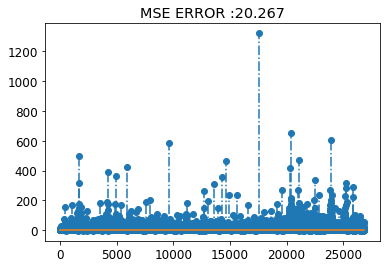

In [ ]:
import matplotlib
import tkinter
from sklearn.metrics import mean_squared_error
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.stem(result.unit_sales-result.predict_sales,linefmt="-.",markerfmt="o",basefmt="-")#绘制误差图
error=np.sqrt(mean_squared_error(result.unit_sales,result.predict_sales))#计算mse并开根号#
plt.title('MSE ERROR :{:.3f}'.format(error))
plt.show()

##Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras 
from keras.datasets import boston_housing 
from keras.models import Sequential 
from keras.layers import Dense  
from keras.callbacks import EarlyStopping 
from sklearn import preprocessing 
from sklearn.preprocessing import scale
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

INFO:tensorflow:Assets written to: best_model.h1/assets
INFO:tensorflow:Assets written to: best_model.h1/assets
INFO:tensorflow:Assets written to: best_model.h1/assets
INFO:tensorflow:Assets written to: best_model.h1/assets
INFO:tensorflow:Assets written to: best_model.h1/assets
INFO:tensorflow:Assets written to: best_model.h1/assets
INFO:tensorflow:Assets written to: best_model.h1/assets
INFO:tensorflow:Assets written to: best_model.h1/assets


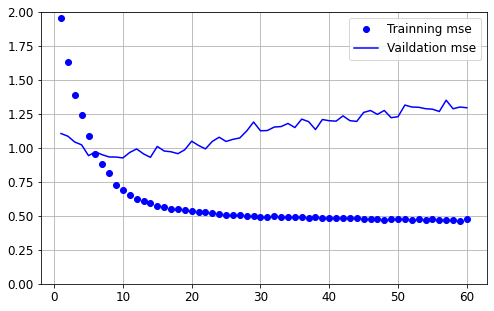

1163/1163 [==============================] - 2s 1ms/step - loss: 1.2955 - mean_squared_error: 1.2955


[1.2954890727996826, 1.2954890727996826]

In [ ]:
mc = ModelCheckpoint(
'best_model.h1', 
monitor='val_mean_squared_error',
save_best_only = True
)

es = EarlyStopping(monitor='val_mean_squared_error', min_delta = 0.001, patience=50)

model1 = keras.models.Sequential([
    keras.layers.AlphaDropout(rate=0.2,input_shape =[X_train_scaled.shape[1]]),
    BatchNormalization( ),
    keras.layers.Dense(10, activation="elu",kernel_initializer=keras.initializers.he_normal(seed=13111985),use_bias=False),
    keras.layers.AlphaDropout(rate=0.2),
     BatchNormalization( ),
    keras.layers.Dense(8, activation="elu",kernel_initializer=keras.initializers.he_normal(seed=13111985),use_bias=False),
    keras.layers.AlphaDropout(rate=0.2),
     BatchNormalization( ),
    keras.layers.Dense(1,activation="linear")
])


model1.compile(loss="mean_squared_error",optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.1, beta_2=0.1),metrics=tf.keras.metrics.MeanSquaredError())

history = model1.fit(X_train_scaled,y_train,epochs=400,validation_data=(X_val_scaled,y_val),verbose=0, batch_size=50,callbacks=[mc,es])
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'bo', label='Trainning mse')
plt.plot(epochs, val_mse, 'b', label='Vaildation mse')
plt.legend() 
plt.grid(True)
plt.gca().set_ylim(0,2)
#save_fig("keras_learning_curves_graph")
plt.show() 
model1.evaluate(X_val_scaled,y_val)

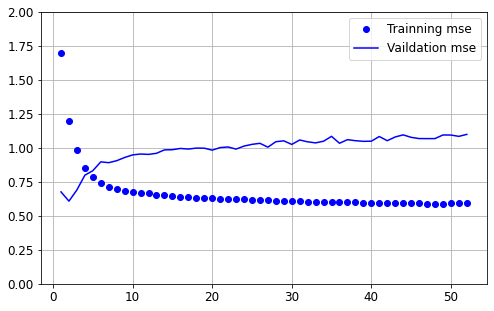

1163/1163 [==============================] - 17s 15ms/step - loss: 1.0994 - mean_squared_error: 1.0994


[1.0994467735290527, 1.0994467735290527]

In [ ]:
mc = ModelCheckpoint(
'best_model.h2', 
monitor='val_mean_squared_error',
save_best_only = True
)

es = EarlyStopping(monitor='val_mean_squared_error', min_delta = 0.001, patience=50)

model2 = keras.models.Sequential([
    keras.layers.AlphaDropout(rate=0.2,input_shape =[X_train_scaled.shape[1]]),
    BatchNormalization( ),
    keras.layers.Dense(6, activation="elu",kernel_initializer=keras.initializers.he_normal(seed=13111985),use_bias=False),
    keras.layers.AlphaDropout(rate=0.2),
    BatchNormalization( ),
    keras.layers.Dense(4, activation="elu",kernel_initializer=keras.initializers.he_normal(seed=13111985),use_bias=False),
    keras.layers.AlphaDropout(rate=0.2),
    BatchNormalization( ),
    keras.layers.Dense(1,activation="linear")
])


model2.compile(loss="mean_squared_error",optimizer=tf.keras.optimizers.Adam(learning_rate=0.000055, beta_1=0.2, beta_2=0.2),metrics=[tf.keras.metrics.MeanSquaredError()])

history = model2.fit(X_train_scaled,y_train,epochs=400,validation_data=(X_val_scaled,y_val),verbose=0,batch_size=50,callbacks=[mc,es])
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'bo', label='Trainning mse')
plt.plot(epochs, val_mse, 'b', label='Vaildation mse')
plt.legend() 
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.rcParams['figure.figsize'] = (8,5)
#save_fig("keras_learning_curves_graph")
plt.show() 
model2.evaluate(X_val_scaled,y_val)

INFO:tensorflow:Assets written to: best_model.h4/assets
INFO:tensorflow:Assets written to: best_model.h4/assets
INFO:tensorflow:Assets written to: best_model.h4/assets
INFO:tensorflow:Assets written to: best_model.h4/assets
INFO:tensorflow:Assets written to: best_model.h4/assets


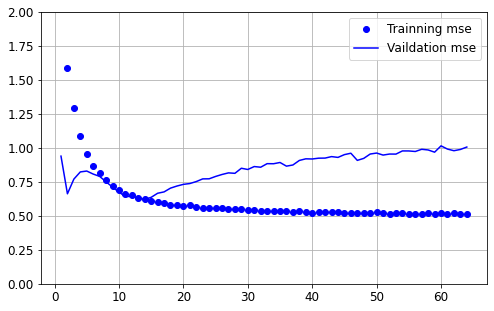

1163/1163 [==============================] - 1s 1ms/step - loss: 1.0063 - mean_squared_error: 1.0063


[1.0063400268554688, 1.0063400268554688]

In [ ]:
mc = ModelCheckpoint(
'best_model.h3', 
monitor='val_mean_squared_error',
save_best_only = True
)

es = EarlyStopping(monitor='val_mean_squared_error', min_delta = 0.001, patience=50)

model3 = keras.models.Sequential([
    keras.layers.AlphaDropout(rate=0.2,input_shape =[X_train_scaled.shape[1]]),
    BatchNormalization( ),
    keras.layers.Dense(6, activation="elu",kernel_initializer=keras.initializers.he_normal(seed=13111985),use_bias=False),
    keras.layers.AlphaDropout(rate=0.2),
    BatchNormalization( ),
    keras.layers.Dense(4, activation="elu",kernel_initializer=keras.initializers.he_normal(seed=13111985),use_bias=False),
    keras.layers.AlphaDropout(rate=0.2),
    BatchNormalization( ),
    keras.layers.Dense(1,activation="linear")
])


model3.compile(loss="mean_squared_error",optimizer=tf.keras.optimizers.Adam(learning_rate=0.000056, beta_1=0.2, beta_2=0.2),metrics=[tf.keras.metrics.MeanSquaredError()])

history = model3.fit(X_train_scaled,y_train,epochs=400,validation_data=(X_val_scaled,y_val),verbose=0,batch_size=100,callbacks=[mc,es])
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'bo', label='Trainning mse')
plt.plot(epochs, val_mse, 'b', label='Vaildation mse')
plt.legend() 
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.rcParams['figure.figsize'] = (8,5)
#save_fig("keras_learning_curves_graph")
plt.show() 
model3.evaluate(X_val_scaled,y_val)

INFO:tensorflow:Assets written to: best_model.h2/assets
INFO:tensorflow:Assets written to: best_model.h2/assets
INFO:tensorflow:Assets written to: best_model.h2/assets
INFO:tensorflow:Assets written to: best_model.h2/assets
INFO:tensorflow:Assets written to: best_model.h2/assets
INFO:tensorflow:Assets written to: best_model.h2/assets
INFO:tensorflow:Assets written to: best_model.h2/assets
INFO:tensorflow:Assets written to: best_model.h2/assets
INFO:tensorflow:Assets written to: best_model.h2/assets
INFO:tensorflow:Assets written to: best_model.h2/assets


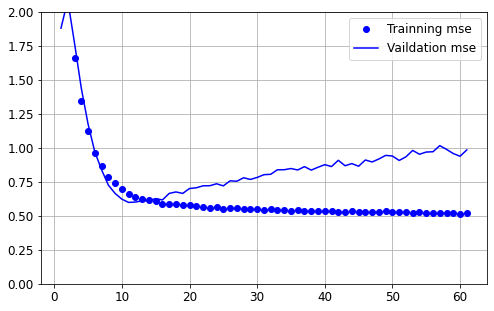

1163/1163 [==============================] - 1s 1ms/step - loss: 0.9853 - mean_squared_error: 0.9853


[0.9852970242500305, 0.9852970242500305]

In [ ]:
mc = ModelCheckpoint(
'best_model.h4', 
monitor='val_mean_squared_error',
save_best_only = True
)

es = EarlyStopping(monitor='val_mean_squared_error', min_delta = 0.001, patience=50)

model4 = keras.models.Sequential([
    keras.layers.AlphaDropout(rate=0.2,input_shape =[X_train_scaled.shape[1]]),
    BatchNormalization( ),
    keras.layers.Dense(6, activation="relu",kernel_initializer=keras.initializers.he_normal(seed=13111985),use_bias=False),
    keras.layers.AlphaDropout(rate=0.2),
     BatchNormalization( ),
    keras.layers.Dense(4, activation="relu",kernel_initializer=keras.initializers.he_normal(seed=13111985),use_bias=False),
    keras.layers.AlphaDropout(rate=0.2),
     BatchNormalization( ),
    keras.layers.Dense(1,activation="linear")
])


model4.compile(loss="mean_squared_error",optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.2, beta_2=0.2),metrics=tf.keras.metrics.MeanSquaredError())

history = model4.fit(X_train_scaled,y_train,epochs=400,validation_data=(X_val_scaled,y_val),verbose=0, batch_size=50,callbacks=[mc,es])
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'bo', label='Trainning mse')
plt.plot(epochs, val_mse, 'b', label='Vaildation mse')
plt.legend() 
plt.grid(True)
plt.gca().set_ylim(0,2)
#save_fig("keras_learning_curves_graph")
plt.show() 
model4.evaluate(X_val_scaled,y_val)

INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


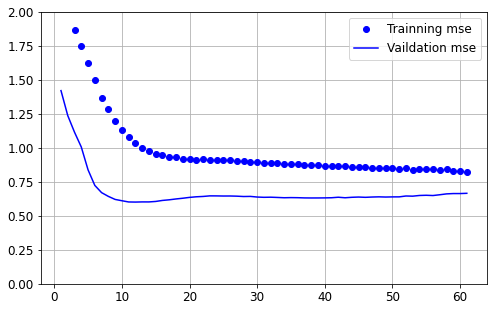

1163/1163 [==============================] - 2s 1ms/step - loss: 0.7451 - mean_squared_error: 0.6659


[0.7450715899467468, 0.665880024433136]

In [ ]:

from keras import regularizers
mc = ModelCheckpoint(
'best_model.h5', 
monitor='val_mean_squared_error',
save_best_only = True
)

es = EarlyStopping(monitor='val_mean_squared_error', min_delta = 0.001, patience=50)

model5 = keras.models.Sequential([
    keras.layers.AlphaDropout(rate=0.2,input_shape =[X_train_scaled.shape[1]]),
    BatchNormalization( ),
    keras.layers.Dense(6,activation="relu",kernel_regularizer=keras.regularizers.l1_l2(0.002,0.1),kernel_initializer=keras.initializers.he_normal(seed=13111985),use_bias=False),
    keras.layers.AlphaDropout(rate=0.2),
    BatchNormalization( ),
    keras.layers.Dense(4, activation="relu",kernel_regularizer=keras.regularizers.l1_l2(0.002,0.1),kernel_initializer=keras.initializers.he_normal(seed=13111985),use_bias=False),
    keras.layers.AlphaDropout(rate=0.2),
    BatchNormalization( ),
    keras.layers.Dense(1,activation="linear")
])


model5.compile(loss="mean_squared_error",optimizer=tf.keras.optimizers.Adam(learning_rate=0.000055,beta_1=0.2,beta_2=0.2),metrics=tf.keras.metrics.MeanSquaredError())

history = model5.fit(X_train_scaled,y_train,epochs=400,validation_data=(X_val_scaled,y_val),verbose=0,batch_size=100,callbacks=[mc,es])
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'bo', label='Trainning mse')
plt.plot(epochs, val_mse, 'b', label='Vaildation mse')
plt.legend() 
plt.grid(True)
plt.gca().set_ylim(0,2)
#save_fig("keras_learning_curves_graph")
plt.show() 
model5.evaluate(X_val_scaled,y_val)

INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


INFO:tensorflow:Assets written to: best_model.h2/assets


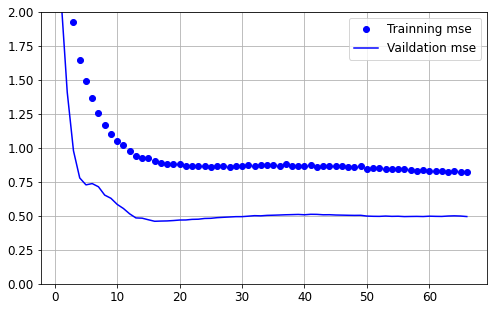

1163/1163 [==============================] - 2s 1ms/step - loss: 0.5896 - mean_squared_error: 0.4948


[0.589585542678833, 0.4948081076145172]

In [ ]:

from keras import regularizers
mc = ModelCheckpoint(
'best_model.h6', 
monitor='val_mean_squared_error',
save_best_only = True
)

es = EarlyStopping(monitor='val_mean_squared_error',min_delta=0.001, patience=50)

model6 = keras.models.Sequential([
    keras.layers.AlphaDropout(rate=0.2,input_shape =[X_train_scaled.shape[1]]),
    BatchNormalization( ),
    keras.layers.Dense(6,activation="relu",kernel_regularizer=keras.regularizers.l1_l2(0.002,0.2),kernel_initializer=keras.initializers.he_normal(seed=13111985),use_bias=False),
    keras.layers.AlphaDropout(rate=0.2),
    BatchNormalization( ),
    keras.layers.Dense(4, activation="relu",kernel_regularizer=keras.regularizers.l1_l2(0.002,0.2),kernel_initializer=keras.initializers.he_normal(seed=13111985),use_bias=False),
    keras.layers.AlphaDropout(rate=0.2),
    BatchNormalization( ),
    keras.layers.Dense(1,activation="linear")
])


model6.compile(loss="mean_squared_error",optimizer=tf.keras.optimizers.Adam(learning_rate=0.000055,beta_1=0.2,beta_2=0.2),metrics=tf.keras.metrics.MeanSquaredError())

history = model6.fit(X_train_scaled,y_train,epochs=400,validation_data=(X_val_scaled,y_val),verbose=0,batch_size=100,callbacks=[mc,es])
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'bo', label='Trainning mse')
plt.plot(epochs, val_mse, 'b', label='Vaildation mse')
plt.legend() 
plt.grid(True)
plt.gca().set_ylim(0,2)
#save_fig("keras_learning_curves_graph")
plt.show() 
model6.evaluate(X_val_scaled,y_val)

In [ ]:
model5.evaluate(X_test_scaled,y_test)

1163/1163 [==============================] - 2s 1ms/step - loss: 1.7215 - mean_squared_error: 1.6268


[1.721532940864563, 1.6267539262771606]

## XGB

###Hypter Parameter Initialization

In [100]:
X_train_scaled = X_train_scaled[X_train_scaled.columns]
X_val_scaled = X_val_scaled[X_val_scaled.columns]
X_test_scaled = X_test_scaled[X_test_scaled.columns]

AttributeError: ignored

In [109]:
from xgboost import XGBRegressor
import optuna
from sklearn.metrics import mean_squared_error
import optuna.integration.xgboost as opxgb

def objective(trial):
    param = {
        'objective':'reg:squarederror',
        'metric':'r2', 
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators',20,300),
        'feature_fraction': trial.suggest_loguniform('feature_fraction',0.01,0.08),
        'bagging_fraction': trial.suggest_loguniform('bagging_fraction',0.01,0.08),
        'bagging_freq':2,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample',[0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate',[0.05,0.1,0.01]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17, 20, 50]),
        'num_leaves' : trial.suggest_int('num_leaves',2,100),
        'min_child_samples': trial.suggest_int('min_child_samples',1,300),
        'min_child_weight':trial.suggest_loguniform('min_child_weight',0.001,0.01)
    }
    
    
    xgb=XGBRegressor(**param)
    xgb.fit(X_train_scaled,y_train,eval_set=[(X_val_scaled,y_val)],early_stopping_rounds=100,verbose=False)
    pred_xgb=xgb.predict(X_val_scaled)
    mse=mean_squared_error(y_val,pred_xgb)
    return mse

In [113]:
study=optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=50,show_progress_bar=True)

[I 2022-08-22 14:56:03,825] A new study created in memory with name: no-name-9757f2d5-cd68-4a73-886a-f5dde0707449
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2022-08-22 14:56:55,763] Trial 0 finished with value: 0.519004762172699 and parameters: {'n_estimators': 108, 'feature_fraction': 0.013280742382404918, 'bagging_fraction': 0.033431868657777, 'reg_alpha': 0.03388710162569386, 'reg_lambda': 0.02553348567060837, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 15, 'num_leaves': 72, 'min_child_samples': 255, 'min_child_weight': 0.0028480543823392315}. Best is trial 0 with value: 0.519004762172699.
[I 2022-08-22 14:57:56,815] Trial 1 finished with value: 0.3541022837162018 and parameters: {'n_estimators': 165, 'feature_fraction': 0.012392057735212606, 'bagging_fraction': 0.06686529771409137, 'reg_alpha': 3.6914395339397497, 'reg_lambda': 0.006791194087651247, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.05, 'max_depth': 11, 'num_leaves': 74, 'min_child_samples': 300, 'min_child_weight': 0.0010646796830915421}. Best is trial 1 with value: 0.3541022837162018.
[I 2022-08-22 14:58:12,939] Trial 

In [114]:
optuna.visualization.plot_param_importances(study)

In [144]:
optuna.visualization.plot_optimization_history(study)

In [116]:
#get the best parameters
params=study.best_params
params['metric'] = 'mse'
params

{'n_estimators': 222,
 'feature_fraction': 0.0378818811410468,
 'bagging_fraction': 0.011969144318218649,
 'reg_alpha': 1.8847439116963356,
 'reg_lambda': 0.0034469036629409563,
 'colsample_bytree': 0.7,
 'subsample': 0.8,
 'learning_rate': 0.05,
 'max_depth': 7,
 'num_leaves': 32,
 'min_child_samples': 153,
 'min_child_weight': 0.007617801063809722,
 'metric': 'mse'}

In [118]:
params={
        'xgb':{#lightgbm
            'estimator':XGBRegressor(objective = 'reg:squarederror',#固定参数
                         metric = 'mse',
                         learning_rate = 0.05,
                         feature_fraction = 0.037,
                         min_child_samples=153,
                         min_child_weight= 0.0076,
                         bagging_fraction = 0.012,
                         bagging_freq = 2,
                         colsample_bytree =0.7,
                         subsample =1,
                         reg_alpha = 1.88,
                         reg_lambda = 0.003
                        ),
            'param_grid':{
            'max_depth': 7,
            'num_leaves':32,
            'n_estimators':222
            }}}

[16:10:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.



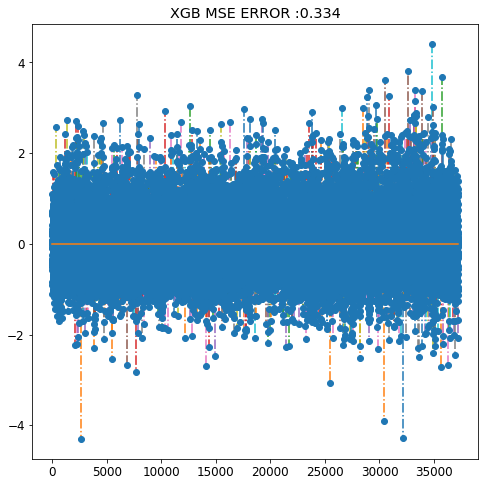

In [143]:
#exam the loss on tran and valid dataset
xgb = XGBRegressor(
        metric = 'mse',
        learning_rate = 0.05,
        feature_fraction = 0.037,
        min_child_samples=153,
        min_child_weight= 0.0076,
        bagging_fraction = 0.012,
        bagging_freq = 2,
        colsample_bytree =0.7,
        subsample =1,
        reg_alpha = 1.88,
        reg_lambda = 0.003,
        max_depth=7,
        num_leaves=32,
        n_estimators=222)

#plot the y_test and predict y_test error
xgb.fit(X_train_scaled,y_train)
plt.stem(xgb.predict(X_test_scaled)-y_test,linefmt="-.",markerfmt="o",basefmt="-")
error=mean_squared_error(y_test,xgb.predict(X_test_scaled))
plt.title('{} MSE ERROR :{:.3f}'.format('xgb'.upper(),error))
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.show()

## LGB

###Hyper Parameter Initialization

In [134]:
from lightgbm import LGBMRegressor
import optuna
from sklearn.metrics import mean_squared_error
import optuna.integration.lightgbm as oplgb

def objective(trial):
    param = {
        'objective':'regression',
        'metric':'mse', 
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators',50,300),
        'feature_fraction': trial.suggest_loguniform('feature_fraction',0.01,0.08),
        'bagging_fraction': trial.suggest_loguniform('bagging_fraction',0.01,0.08),
        'bagging_freq':2,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample',[0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate',[0.05,0.1,0.01]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17, 20, 50]),
        'num_leaves' : trial.suggest_int('num_leaves',2,100),
        'min_child_samples': trial.suggest_int('min_child_samples',1,300),
        'min_child_weight':trial.suggest_loguniform('min_child_weight',0.001,0.01)
    }
    
    lgb=LGBMRegressor(**param)
    lgb.fit(X_train_scaled,y_train,eval_set=[(X_val_scaled,y_val)],early_stopping_rounds=100,verbose=False)
    pred_lgb=lgb.predict(X_val_scaled)
    mse=mean_squared_error(y_val,pred_lgb)
    return mse

In [135]:
study=optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=50,show_progress_bar=True)

[I 2022-08-22 15:50:26,303] A new study created in memory with name: no-name-b18ebf2c-06c2-48f4-a29b-ed27a9379dfe
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2022-08-22 15:50:27,602] Trial 0 finished with value: 0.5101429570386055 and parameters: {'n_estimators': 232, 'feature_fraction': 0.07669567676223397, 'bagging_fraction': 0.019372325635547808, 'reg_alpha': 2.9991949210868483, 'reg_lambda': 0.13243104794715368, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.05, 'max_depth': 50, 'num_leaves': 9, 'min_child_samples': 247, 'min_child_weight': 0.00807953855218065}. Best is trial 0 with value: 0.5101429570386055.
[I 2022-08-22 15:50:29,561] Trial 1 finished with value: 0.40362553015497654 and parameters: {'n_estimators': 235, 'feature_fraction': 0.030297304091117607, 'bagging_fraction': 0.04089947069409993, 'reg_alpha': 1.929080088004111, 'reg_lambda': 0.02289714411704258, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 15, 'num_leaves': 8, 'min_child_samples': 129, 'min_child_weight': 0.0010202151811579162}. Best is trial 1 with value: 0.40362553015497654.
[I 2022-08-22 15:50:31,065] Trial 2 

In [136]:
optuna.visualization.plot_param_importances(study)

In [137]:
optuna.visualization.plot_optimization_history(study)

In [138]:
params=study.best_params
params['metric'] = 'mse'
params

{'n_estimators': 228,
 'feature_fraction': 0.07653887851788646,
 'bagging_fraction': 0.05954134391446944,
 'reg_alpha': 0.007929541833873517,
 'reg_lambda': 0.01195091068496111,
 'colsample_bytree': 1.0,
 'subsample': 0.4,
 'learning_rate': 0.05,
 'max_depth': 17,
 'num_leaves': 52,
 'min_child_samples': 39,
 'min_child_weight': 0.005016054288512358,
 'metric': 'mse'}

In [139]:
params={
          'xgb':{
            'estimator':XGBRegressor(objective = 'reg:squarederror',
                         metric = 'mse',
                         learning_rate = 0.1,
                         feature_fraction = 0.037,
                         min_child_samples=153,
                         min_child_weight= 0.0076,
                         bagging_fraction = 0.071,
                         bagging_freq = 2,
                         colsample_bytree =0.7,
                         subsample =1,
                         reg_alpha = 3.05,
                         reg_lambda = 0.51
                        ),
            'param_grid':{
            'max_depth':7,
            'num_leaves':32,
            'n_estimators':222
            }},
        'lgb':{
            'estimator':LGBMRegressor(objective = 'regression',
                         metric = 'mse',
                         learning_rate = 0.05,
                         feature_fraction =0.07,
                         min_child_samples=39,
                         min_child_weight=0.005,
                         bagging_fraction =0.06,
                         bagging_freq = 2,
                         colsample_bytree = 1,
                         subsample =0.4,
                         reg_alpha =0.008,
                         reg_lambda = 0.012
                        ),
            'param_grid':{
            'max_depth':17,
            'num_leaves':52,
            'n_estimators':232
            }}}

###Prediction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.



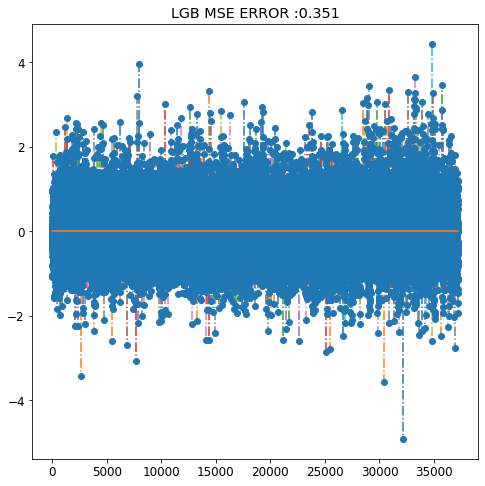

In [142]:
lgb = LGBMRegressor(
        metric = 'mse',
        learning_rate = 0.05,
        feature_fraction =0.07,
        min_child_samples=39,
        min_child_weight=0.005,
        bagging_fraction =0.06,
        bagging_freq = 2,
        colsample_bytree = 1,
        subsample =0.4,
        reg_alpha =0.008,
        reg_lambda = 0.012,
        max_depth=17,
        num_leaves=52,
        n_estimators=232)


#plot the y_test and predict y_test error
lgb.fit(X_train_scaled,y_train)
plt.stem(lgb.predict(X_test_scaled)-y_test,linefmt="-.",markerfmt="o",basefmt="-")
error=mean_squared_error(y_train,lgb.predict(X_train_scaled))
plt.title('{} MSE ERROR :{:.3f}'.format('lgb'.upper(),error))
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.show()